In [1]:
import sys
import os
from pathlib import Path
from hydra import initialize, compose
initialize(config_path="../confs", job_name="notebook")

sys.path.append(os.path.abspath("../src"))
# We change the working directory to the root of the project
# Run this only once
root_path = Path.cwd().parent
os.chdir(root_path)
sys.path.append(root_path / "src")

/tmp/ipykernel_9617/1901343020.py:5: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../confs", job_name="notebook")


In [2]:
from src.utils import torch_to_pil
from src.character_linking.feature_matching import featureMatching
from src.character_linking.params import HOGParameters, featureMatchingParameters, fullHOGOutput, featureMatchingOutputs
from src.utils import connectedComponent
from src.patch_processing.patch_extraction import extract_patches

from notebook_utils.descriptor import compute_hog, visualize_hog
from notebook_utils.deepseek import get_character_meaning, get_character_meanings_ordered, display_character_or_error, display_character_with_meaning

from einops import rearrange
import torch

import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

from PIL import Image

In [3]:
from notebook_utils.parquet_utils import load_dataframe, save_dataframe

patches_df = load_dataframe('data/processed/book1_columnwise')

Loading column: bin_patch
Loading column: img_patch
Loading column: page
Loading column: file
Loading column: left
Loading column: top
Loading column: width
Loading column: height
Loading column: svg
Loading column: aspect_ratio
Loading column: predicted_char
Loading column: histogram
✓ Loaded from data/processed/book1_columnwise


In [4]:
histograms = torch.tensor(patches_df['histogram']).to(device='cuda')
patches_df['predicted_char']

/tmp/ipykernel_9617/1035913153.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538437738/work/torch/csrc/utils/tensor_new.cpp:278.)
  histograms = torch.tensor(patches_df['histogram']).to(device='cuda')


0        最
1        著
2        帶
3        西
4         
        ..
13514    近
13515    文
13516    在
13517    眾
13518     
Name: predicted_char, Length: 13519, dtype: object

In [5]:
from notebook_utils.viz import show_random_sample
from IPython.display import display, Markdown, Latex


subset = patches_df.sample(5, ignore_index=True)

# show_random_sample(subset['svg'], subset['predicted_char'], n_samples=len(subset), scale=2)

for i in range(len(subset)):
    display_character_or_error(subset['svg'][i], subset['predicted_char'][i])


* Ask Camillo
* Generate report
* => Stats and OCR results and majority for every cluster
* => Aggregate information

- Number of chars per cluster => + majority voting => entropy of predictions
- Study happax more in details => stats etc; similar characters (NNs) ; OCR interpretation
- Study purity without happax

- Comparisons for parameters -> graphs etc
- Use OCR to split
- 

## Computing the matches

Now that we have the descriptors, we will use Rabin's et al. methodology to match the SIFT descriptors. We will explain, step by step, how it works:

## Statistical test for descriptor matching

**Based on [this paper](https://hal.science/hal-00168285/document) and ideas by Aitor Artola**

### Framework and notation

Let $a^i = (a^i_1, \ldots, a^i_M)$ and $b = (b_1, \ldots, b_M)$ be two descriptor vectors with $M$ vector components (e.g., histograms).

**Global dissimilarity measure**:
$$D(a^i, b) = \sum_{m=1}^{M} d(a^i_m, b_m)$$
where $d(\cdot, \cdot)$ is a dissimilarity measure between components (Euclidean distance, Circular Earth Mover Distance, etc.).

### Null hypothesis

**$\mathcal{H}_0^i$**: The random variables $\{d(a^i_m, b_m)\}_{m=1}^M$ are mutually independent.

Under this hypothesis, each $d(a^i_m, b_m)$ is a random variable with density $p_m$, mean $\mu_m$, and variance $\sigma_m^2$.

### Probability under the null hypothesis

The probability that the global dissimilarity is below a threshold $\delta$ is:
$$\mathbb{P}\left(D(a^i, b) \leq \delta \mid \mathcal{H}_0^i\right) = \mathbb{P}\left(\sum_{m=1}^{M} d(a^i_m, b_m) \leq \delta\right)$$

This probability corresponds to the cumulative distribution function of the sum of independent random variables:
$$\mathbb{P}\left(D(a^i, b) \leq \delta \mid \mathcal{H}_0^i\right) = (p_1 * p_2 * \cdots * p_M)(\delta)$$
where $*$ denotes convolution.

### Normal approximation (CLT)

**Theorem (Lindeberg-Feller CLT)**: Let $X_m = d(a^i_m, b_m)$ be independent random variables with $\mathbb{E}[X_m] = \mu_m$ and $\text{Var}(X_m) = \sigma_m^2$. Define:
$$S_M = \sum_{m=1}^M X_m, \quad s_M^2 = \sum_{m=1}^M \sigma_m^2$$

Under appropriate regularity conditions (Lindeberg condition and Feller condition), we have:
$$\frac{S_M - \mathbb{E}[S_M]}{s_M} = \frac{\sum_{m=1}^M (X_m - \mu_m)}{s_M} \xrightarrow[\text{dist}]{M \to \infty} \mathcal{N}(0, 1)$$

**In practice**, for fixed and sufficiently large $M$, under $\mathcal{H}_0^i$:
$$D(a^i, b) \approx \mathcal{N}\left(\mu_{\text{tot}}, \sigma_{\text{tot}}^2\right)$$
with $\mu_{\text{tot}} = \sum_{m=1}^M \mu_m$ and $\sigma_{\text{tot}}^2 = \sum_{m=1}^M \sigma_m^2$ (finite quantities).

This approximation is justified when:
1. The $d(a^i_m, b_m)$ are independent
2. The Feller condition is verified
3. $M$ is large enough for the normal approximation to be accurate

### Statistical test

We compute the $p$-value:
$$p\text{-value} = \mathbb{P}\left(D(a^i, b) \leq \delta_{\text{obs}} \mid \mathcal{H}_0^i\right) \approx \Phi\left(\frac{\delta_{\text{obs}} - \mu_{\text{tot}}}{\sigma_{\text{tot}}}\right)$$
where $\Phi$ is the cumulative distribution function of the standard normal distribution.

We reject $\mathcal{H}_0^i$ (the descriptors do not match) if this $p$-value is too low. When comparing $N_Q$ query descriptors against $N_C$ candidates, the matching threshold for a given $\varepsilon > 0$ is obtained by finding the largest $\delta$ such that:
$$\Phi\left(\frac{\delta - \mu_{\text{tot}}}{\sigma_{\text{tot}}}\right) \leq \frac{\varepsilon}{N_Q N_C}$$

Since $\Phi$ is monotonically increasing, this gives:
$$\frac{\delta_i(\varepsilon) - \mu_{\text{tot}}}{\sigma_{\text{tot}}} = \Phi^{-1}\left(\frac{\varepsilon}{N_Q N_C}\right)$$

Therefore:
$$\delta_i(\varepsilon) = \mu_{\text{tot}} + \sigma_{\text{tot}} \cdot \Phi^{-1}\left(\frac{\varepsilon}{N_Q N_C}\right)$$

A match between $a^i$ and $b^j$ is **$\varepsilon$-meaningful** if $D(a^i, b^j) \leq \delta_i(\varepsilon)$. Under $\mathcal{H}_0^i$, the expected number of $\varepsilon$-meaningful matches is bounded by $\varepsilon$.


# Dissimilarity measures

In practice, the dissmiliraties $d(\cdot, \cdot)$ between two components $a^i_m$ and $b_m$ are implemented as either:
- Euclidean distance
- Circular Earth Mover Distance (CEMD)

The CEMD is a distance introduced in the same paper, and is an adaption of the Earth Mover Distance for circular histograms. We describe it briefly in the following section:

## Circular Earth Mover Distance (CEMD)

**Based on [this paper](https://hal.science/hal-00168285/document)**.

The Earth Mover Distance is the Wasserstein-1 metric, which compares two probability measures $\mu$ and $\nu$. In the general case, given a metric space $(M, c)$, it is formulated as $W_1(\mu, \nu) = \inf \limits_{\gamma \in \Gamma(\mu, \nu)} \mathbb{E}_{(x,y)\sim\gamma}\left[ c(x, y)\right]$, where $\Gamma(\mu, \nu)$ is the set of all couplings between $\mu$ and $\nu$. For two discrete histograms $f$ and $g$ with $N$ bins, their EMD is defined as $\text{EMD}(f, g) = \min_{\alpha_{i, j} \in \mathcal{M}} \sum \limits_{i=1}^N \sum \limits_{j=1}^N \alpha_{i,j} c(i, j)$, with $\mathcal{M}$ the set of all couplings between $f$ and $g$.

For circular histograms, we use:
$$c(i,j) = \frac{1}{N} \min(|i-j|, N - |i-j|), \quad \forall (i,j) \in \{1, \ldots N\}^2.$$

When the distance is $c(i, j) = \frac{1}{N} | i-j |$ (non-circular case), it is well-known that EMD equals the $\ell_1$ distance between cumulative histograms: $\text{EMD}(f, g) = \|F - G\|_1 = \frac{1}{N}\sum_{i=1}^N |F[i] - G[i]|$, where $F[i] = \sum_{j=1}^i f[j]$ and $G[i] = \sum_{j=1}^i g[j]$.

Rabin et al. proved that for circular histograms with the circular ground distance, the Circular Earth Mover's Distance (CEMD) can be efficiently computed as:

$$\text{CEMD}(f, g) = \min_{k \in \{1,\ldots N\}} \|F_k - G_k\|_1$$

where $F_k$ and $G_k$ are cumulative histograms of $f$ and $g$ starting at the $k$-th bin.


**We now compute matches and their negative log false alarm rates (NLFA) using the HOG descriptor and Euclidean distance within the a contrario framework. The NLFA represents the negative log of the p-value: high values indicate matches that are statistically unlikely under the independence hypothesis.**

In [6]:
eps = 50 #! EXTREMELY IMPORTANT PARAMETER FOR GRAPH BASED CLUSTERING

featureMatching_params = featureMatchingParameters(
    metric          = "CEMD",                           # The dissimilarity measure - could have been 'L2'
    epsilon         = eps,                              # Expected number of false matches over the dataset
    reciprocal_only = True,                             # not used
    partial_output  = False,                            # not used
    distribution='normal'                               # not used
)
feature_matcher = featureMatching(featureMatching_params)

# matches, nlfa, dissimilarities = feature_matcher.match(histograms, histograms)
# Matches: 
# -> List of matches under our model; (N_matches, 2) array
# NLFA:
# -> conceptually similar to the neg log probability of match under our model
# -> shape: (N_images, N_images)
# dissimilarities:
# -> the CEMD distance metric between all the samples
# -> shape: (N_image, N_images)

# torch.save(nlfa, 'data/tmp/nlfa')



## For Edwin:

We would like to investigate different clustering algorithms for grouping HOG descriptors of traditional Chinese characters. There are two main approaches:

### 1. Classical clustering: KMeans, Bisecting KMeans, ...

These algorithms are well-established and can be found [here](https://scikit-learn.org/stable/modules/clustering.html). They operate on coordinate representations in $\mathbb{R}^d$ and typically rely on Euclidean distance as the underlying metric.

### 2. Graph-based clustering algorithms

Some of these algorithms are also covered in the previous link. This class of algorithms is considerably broader, as they often only require a notion of similarity, dissimilarity, or connectivity—rather than explicit coordinate embeddings. This flexibility is particularly relevant for our use case, where dissimilarity measures like CEMD or NLFA may not correspond to a simple Euclidean metric.

---

**Our objectives:**

- **Investigate the most common classical clustering algorithms** (e.g., KMeans, Bisecting KMeans, Hierarchical Agglomerative Clustering) and evaluate their suitability for grouping HOG descriptors of Chinese characters.

- **Explore graph-based clustering methods** (e.g., Spectral Clustering, DBSCAN, Affinity Propagation, Louvain, ...) that can leverage the dissimilarity measures described in the matching framework—particularly the Circular Earth Mover Distance (CEMD) or the NLFA-based matching criterion—without requiring an explicit Euclidean embedding.

- **Compare clustering performance** using Euclidean distance, CEMD, and NLFA as the underlying dissimilarity measures. The goal is to determine which metric best captures character identity, i.e., which produces clusters that naturally group instances of the same character together.

- **Assess scalability and computational cost.** Matching $N_Q$ query descriptors against $N_C$ candidates can be expensive, and this cost compounds when combined with clustering. In particular, some graph-based algorithms (e.g., Spectral Clustering, Affinity Propagation) scale poorly—often $O(N^2)$ or $O(N^3)$—and may become impractical for large character datasets.

---

**Context:**

- We compute **HOG (Histogram of Oriented Gradients) descriptors** for each character instance.
- These descriptors are currently matched using an **NLFA-based statistical test** that controls the expected number of false matches.
- The ultimate goal is to find a clustering that **naturally groups instances of the same traditional Chinese character together**, enabling unsupervised or semi-supervised character recognition.

---

**Suggested experiments:**

1. **Baseline**: Run KMeans with Euclidean distance on raw HOG descriptors. Evaluate cluster purity with respect to ground-truth character labels using the code (see section "**Clustering Evaluation**).

2. **Graph construction**: In this code, we build a similarity graph NLFA-based $\varepsilon$-meaningful matches. Apply graph-based clustering (Louvain, Spectral Clustering, or Chinese Whispers). We show an example on how to do it using the Leiden algorithm.

3. **Comparison metrics**: Use Adjusted Rand Index (ARI), Normalized Mutual Information (NMI), and cluster purity to compare methods. Log carefully these metrics into a small report.

4. **Scalability test**: Measure runtime for each algorithm.


_____
# Graph Construction - Example

In [7]:
nlfa = torch.load('data/tmp/nlfa').to(device='cuda')

/tmp/ipykernel_9617/1407551614.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nlfa = torch.load('data/tmp/nlfa').to(device='cuda')


**We only keep the reciprocal matches: the nlfa should be above a threshold in both directions.**

In [8]:
nlfa_threshold = feature_matcher.nlfa_theshold(histograms, histograms)

reciprocal = torch.logical_and(nlfa >= nlfa_threshold, nlfa.T >= nlfa_threshold)
matches = torch.nonzero(reciprocal, as_tuple=False) #! MATCHES FOR THE GRAPH BASED ALGORITHMS - DEFINES THE EDGES OF THE GRAPH
matches = matches[matches[:,0] != matches[:, 1]]
del reciprocal # free the memory

print('Number of matches :', len(matches))
print('Number of patches:', len(histograms))
print(f'Average number of matches per patch: {len(matches) / len(histograms):.1f}')

Number of matches : 842258
Number of patches: 13519
Average number of matches per patch: 62.3


**Let's show the average number of matches per image as a function of the nlfa threshold**:

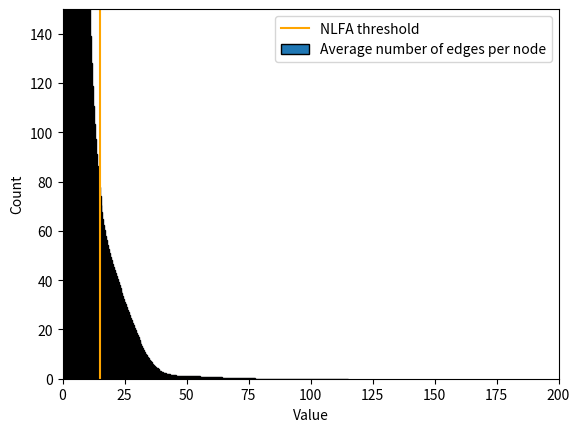

In [9]:
nlfa_threshold = -(np.log(eps) - 2 * np.log(len(histograms)))
hist, bin_edges = torch.histogram(nlfa.reshape(-1).cpu(), bins=300)
cumhist = torch.flip(hist, dims=[0]).cumsum(0).flip(0)
avrg_neighbors = cumhist / len(histograms)
# Calculate bin centers and widths

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = bin_edges[1:] - bin_edges[:-1]

# Create bar plot
plt.bar(bin_centers, avrg_neighbors, width=bin_widths, edgecolor='black', align='center', label="Average number of edges per node")
plt.axvline(nlfa_threshold, c='orange', label='NLFA threshold')
plt.xlabel('Value')
plt.ylabel('Count')
plt.ylim(0,150)
plt.xlim(0,200)
plt.legend()
plt.show()


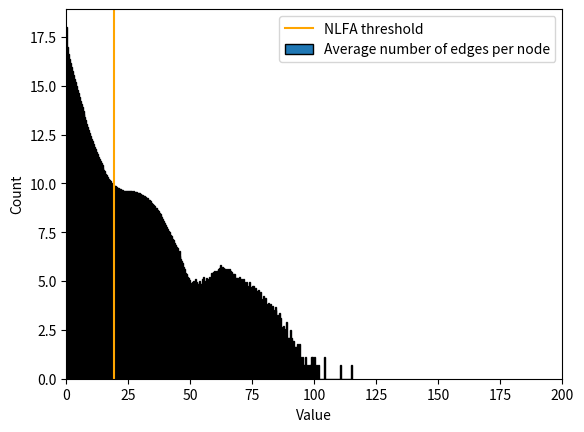

In [10]:
# eps = 0.002538207298140153
eps = 0.8

nlfa_threshold = -(np.log(eps) - 2 * np.log(len(histograms)))
# nlfa_threshold = 25
hist, bin_edges = torch.histogram(nlfa.reshape(-1).cpu(), bins=300)
cumhist = torch.flip(hist, dims=[0]).cumsum(0).flip(0)
avrg_neighbors = cumhist / len(histograms)
# Calculate bin centers and widths

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = bin_edges[1:] - bin_edges[:-1]

# Create bar plot
plt.bar(bin_centers, torch.log(hist+1), width=bin_widths, edgecolor='black', align='center', label="Average number of edges per node")
plt.axvline(nlfa_threshold, c='orange', label='NLFA threshold')
plt.xlabel('Value')
plt.ylabel('Count')
# plt.ylim(0,150)
plt.xlim(0,200)
plt.legend()
plt.show()


**We show the distribution of dissimilarities for one character:**

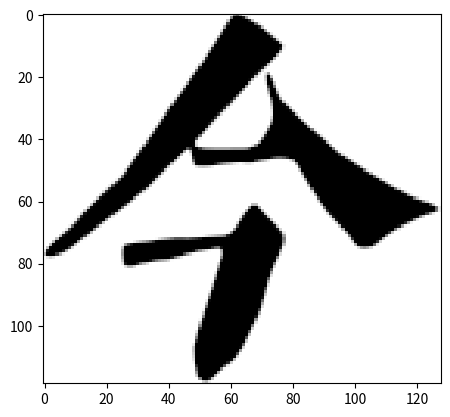

/tmp/ipykernel_9617/2371014867.py:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  gaussian = (1 / np.sqrt(2 * np.pi * var_tot)) * np.exp(-0.5 * ((x - mu_tot) / np.sqrt(var_tot))**2)


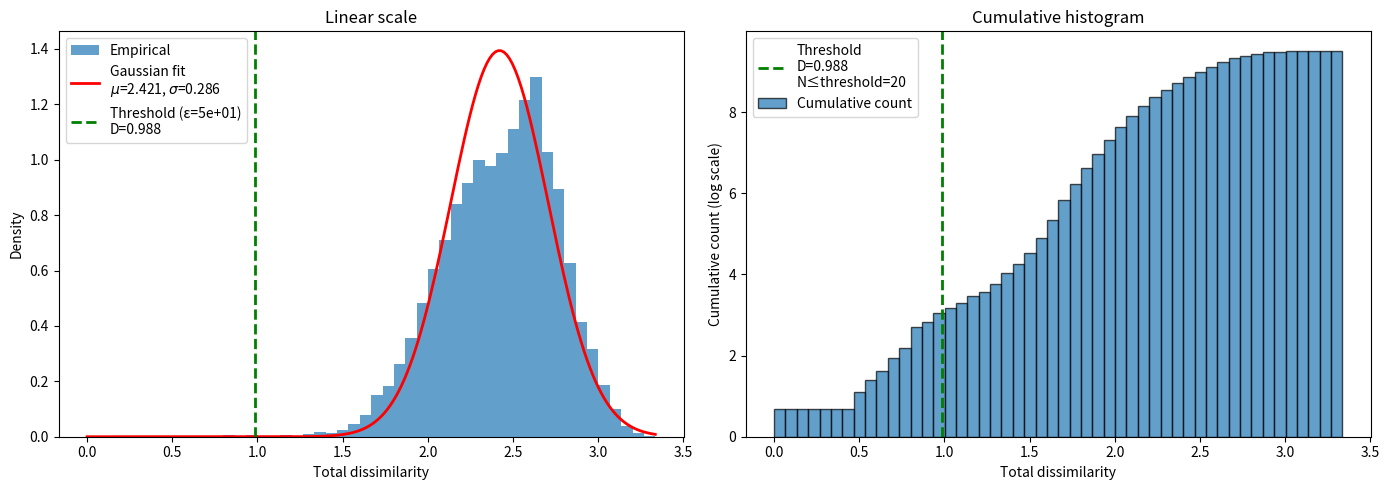

In [11]:
# Statistics for the dissimilarities of one random histogram $(a_1, ..., a_M)$ against all others.
N, N_cells, N_bins = histograms.shape
NBINS = 50


# patches = images.squeeze(1).cpu()

idx_start = np.random.randint(N)
queries = histograms[idx_start:idx_start+1]
dissim = feature_matcher.compute_dissimilarities(queries, histograms)


# show the distribution

total_dissim = dissim.sum(-1).reshape(-1).cpu()
mu_tot   = dissim.mean(dim=1).sum(dim=1).item()
var_tot  = dissim.var(dim=1).sum(dim=1).item()*2

plt.imshow(patches_df['svg'][idx_start].render(), cmap='gray')
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original plot
ax = axes[0]
ax.hist(total_dissim.numpy(), bins=NBINS, density=True, alpha=0.7, label='Empirical')

# Add Gaussian overlay
x = np.linspace(total_dissim.min(), total_dissim.max(), 200)
gaussian = (1 / np.sqrt(2 * np.pi * var_tot)) * np.exp(-0.5 * ((x - mu_tot) / np.sqrt(var_tot))**2)
ax.plot(x, gaussian, 'r-', linewidth=2, label=f'Gaussian fit\n$\mu$={mu_tot:.3f}, $\sigma$={np.sqrt(var_tot):.3f}')

# Add dissimilarity threshold
eps = feature_matcher._params.epsilon
nlfa_threshold = -(np.log(eps) - 2 * np.log(len(histograms)))

# Convert NLFA threshold to dissimilarity threshold using inverse Gaussian CDF
from scipy.stats import norm
dissim_threshold = mu_tot + np.sqrt(var_tot) * norm.ppf(np.exp(-nlfa_threshold))

ax.axvline(dissim_threshold, color='g', linestyle='--', linewidth=2, 
            label=f'Threshold (ε={eps:.0e})\nD={dissim_threshold:.3f}')

ax.legend()
ax.set_xlabel('Total dissimilarity')
ax.set_ylabel('Density')
ax.set_title('Linear scale')

# Cumulative histogram (log scale) for tail visualization
ax = axes[1]
hist, bin_edges = torch.histogram(total_dissim, bins=NBINS)
cumhist = torch.log(1+hist.cumsum(0))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = bin_edges[1:] - bin_edges[:-1]

# Count elements under threshold
n_under_threshold = (total_dissim <= dissim_threshold).sum().item()

ax.bar(bin_centers.numpy(), cumhist.numpy(), width=bin_widths.numpy(), 
       edgecolor='black', alpha=0.7, align='center', label='Cumulative count')
ax.axvline(dissim_threshold, color='g', linestyle='--', linewidth=2, 
           label=f'Threshold\nD={dissim_threshold:.3f}\nN≤threshold={n_under_threshold}')

ax.legend()
ax.set_xlabel('Total dissimilarity')
ax.set_ylabel('Cumulative count (log scale)')
ax.set_title('Cumulative histogram')

plt.tight_layout()
plt.show()

**Remark: Sometimes, the distribution does not seem gaussian at all This is very bad news as it is how we compute the threshold. Note: the EPS parameter should choosen such that, whenever there are multiple true matches for a character, the threshold on the right plot should be on the right of all the true matches and on the left of wrong matches. For common characters, the cumulative histogram should look like a step function, and the threshold should be in the middle of the intermediary step**

Showing 20 out of 20 elements under threshold (sorted by distance):


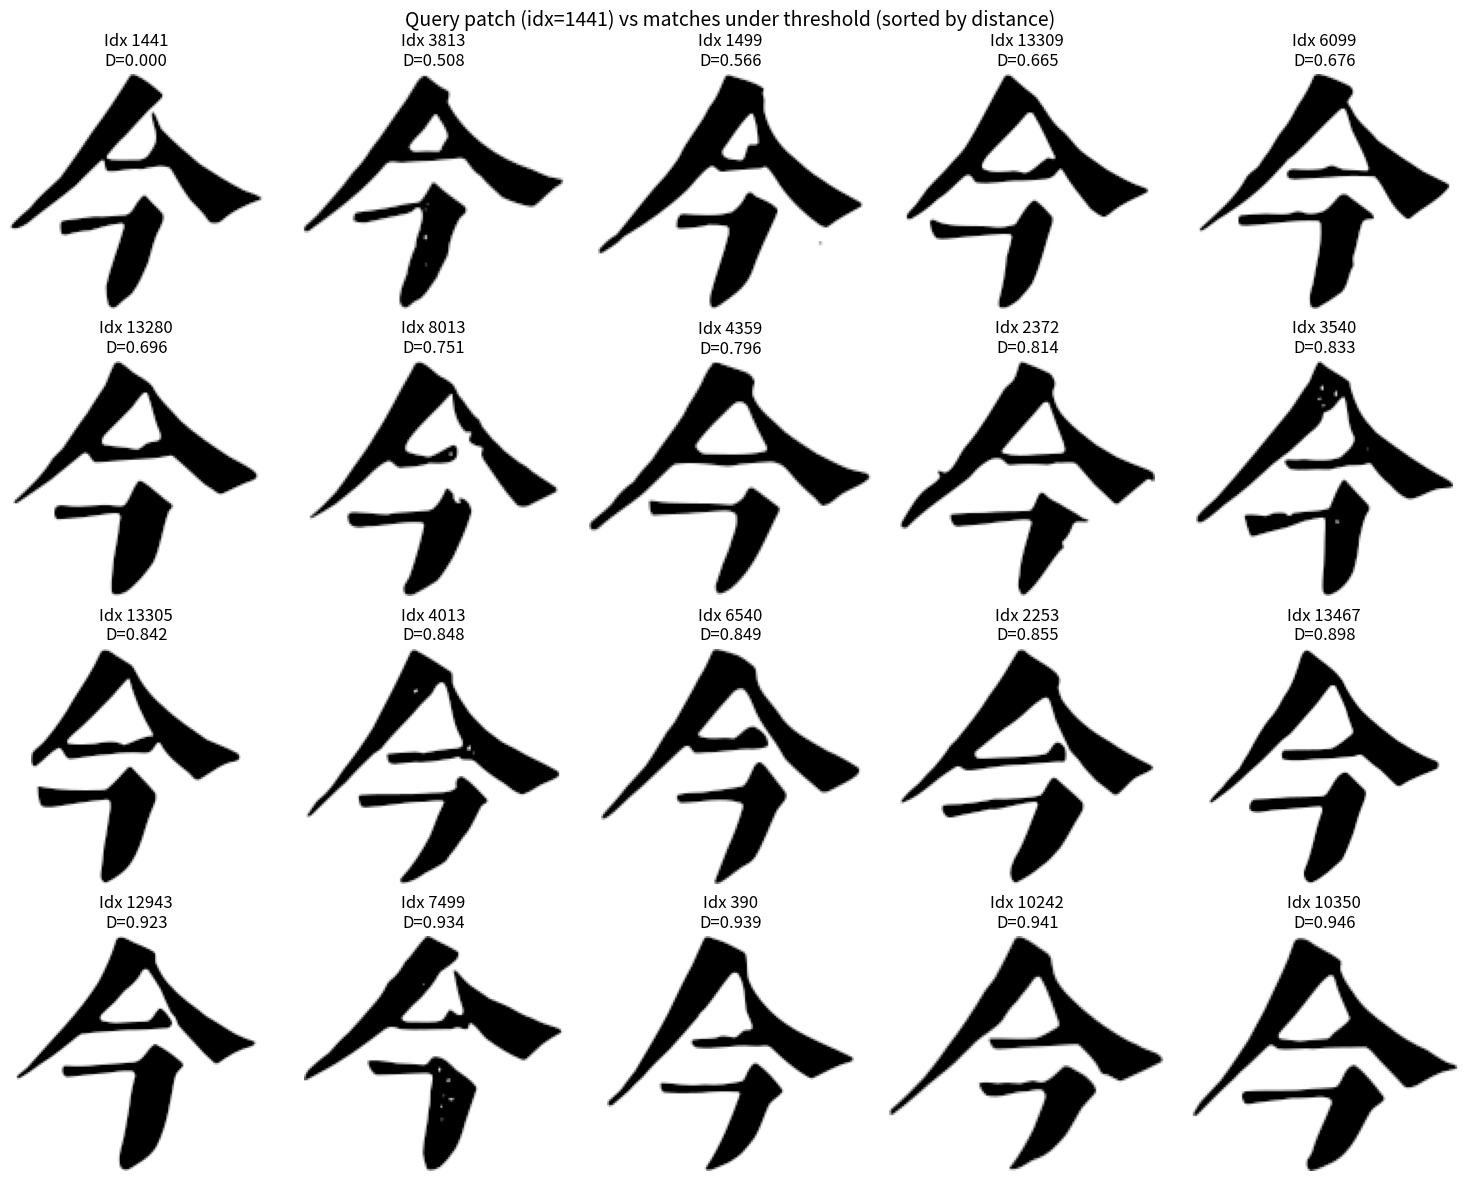

In [12]:
# Show elements under the threshold (limit to 20), sorted by distance
under_threshold_mask = total_dissim <= dissim_threshold
under_threshold_indices = torch.where(under_threshold_mask)[0]
under_threshold_dissim = total_dissim[under_threshold_mask]

# Sort by dissimilarity
sorted_indices = torch.argsort(under_threshold_dissim)
sorted_under_threshold_indices = under_threshold_indices[sorted_indices]
sorted_dissim_values = under_threshold_dissim[sorted_indices]

n_to_show = min(20, len(sorted_under_threshold_indices))

print(f"Showing {n_to_show} out of {len(sorted_under_threshold_indices)} elements under threshold (sorted by distance):")

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

for i in range(n_to_show):
    idx = sorted_under_threshold_indices[i].item()
    dissim_value = sorted_dissim_values[i].item()
    
    patch_img = patches_df['svg'][idx].render()
    axes[i].imshow(patch_img, cmap='gray')
    axes[i].set_title(f'Idx {idx}\nD={dissim_value:.3f}')
    axes[i].axis('off')

# Hide unused subplots
for i in range(n_to_show, 20):
    axes[i].axis('off')

plt.suptitle(f'Query patch (idx={idx_start}) vs matches under threshold (sorted by distance)', fontsize=14)
plt.tight_layout()
plt.show()

_____
# Graph creation and clustering

Here, we show how to create the graph and use it to compute clustering assignments. We begin by creating the graph:

In [13]:
N = len(histograms)

edge_weights = nlfa  # Here, we put the NLFA on the edges. Other options should be explored and compared, such as the CEMD dissimilarity.

import networkx as nx

print("Building graph...")
G = nx.Graph()
G.add_nodes_from(range(N))          # One node for every image
edges = [(int(i.item()), int(j.item()), edge_weights[i, j].item()) for i, j in matches if i != j]  
G.add_weighted_edges_from(edges)    # Add the weights


Building graph...


**We run the Leiden algorithm and assign the clustering result to ```patches_df['community']```:**

In [16]:

gamma = 100 #! Important parameter for the Leiden algorithm



import igraph as ig
import leidenalg as la

G_ig = ig.Graph.from_networkx(G)
partition = la.find_partition(G_ig, la.RBConfigurationVertexPartition, resolution_parameter=gamma)

patches_df['community'] = partition.membership
patches_df['svg_str'] = patches_df['svg'].map(lambda x:x.to_string())

save_dataframe(patches_df.drop(columns=['svg']), 'data/extracted/tmp/clustered')
import pickle
pickle.dump(G, open('data/extracted/tmp/graph.pckl', 'wb'))

Saving column: bin_patch
Saving column: img_patch
Saving column: page
Saving column: file
Saving column: left
Saving column: top
Saving column: width
Saving column: height
Saving column: aspect_ratio
Saving column: predicted_char
Saving column: histogram
Saving column: community
Saving column: svg_str
✓ Saved to data/extracted/tmp/clustered


**Some utilty functions:**

In [ ]:
communities = []
for i in range(len(partition)):
    community = set([node for node, comm in enumerate(partition.membership) if comm == i])
    communities.append(community)


def get_random_happax(communities):
    i = np.random.randint(0, len(communities))
    if len(communities[i]) > 1:
        return get_random_happax(communities)
    return communities[i].pop()


def get_random_easy(communities):
    i = np.random.randint(0, len(communities))
    if len(communities[i]) < 60:
        return get_random_easy(communities)
    return communities[i].pop()

def get_community(communities, min_size=None, max_size=None):
    i = np.random.randint(0, len(communities))
    if min_size is not None and len(communities[i])<min_size:
        return get_community(communities, min_size, max_size)
    if max_size is not None and len(communities[i])>max_size:
        return get_community(communities, min_size, max_size)
    return i


In [ ]:
from src.patch_processing.renderer import Renderer

# Usage
dpi = 256
scale = 0.1
min_size_black = 75 * scale**2
min_size_white = 20 * scale**2

dataset = Renderer(
    svg_imgs=patches_df['svg'],
    min_size_black=min_size_black,
    min_size_white=min_size_white,
    scale=scale,
    bin_thresh=128,
    dpi=dpi,
    pad_to_multiple=32
)

# Access canvas dimensions
canvas_width = dataset.canvas_width
canvas_height = dataset.canvas_height
center_x = dataset.center_x
center_y = dataset.center_y

print(f"Canvas size: {canvas_width} x {canvas_height} pixels")

Rendering:   0%|          | 0/13519 [00:00<?, ?img/s]

Rendering: 100%|██████████| 13519/13519 [01:24<00:00, 159.17img/s]

Canvas dimensions: w=192, h=192, cx=94, cy=97
Canvas size: 192 x 192 pixels


______
# Clustering Evaluation

**Show the results for random samples (run multiple times this cell):**


Community 93 Analysis
Community size: 35 patches
PCA computed with 10 components


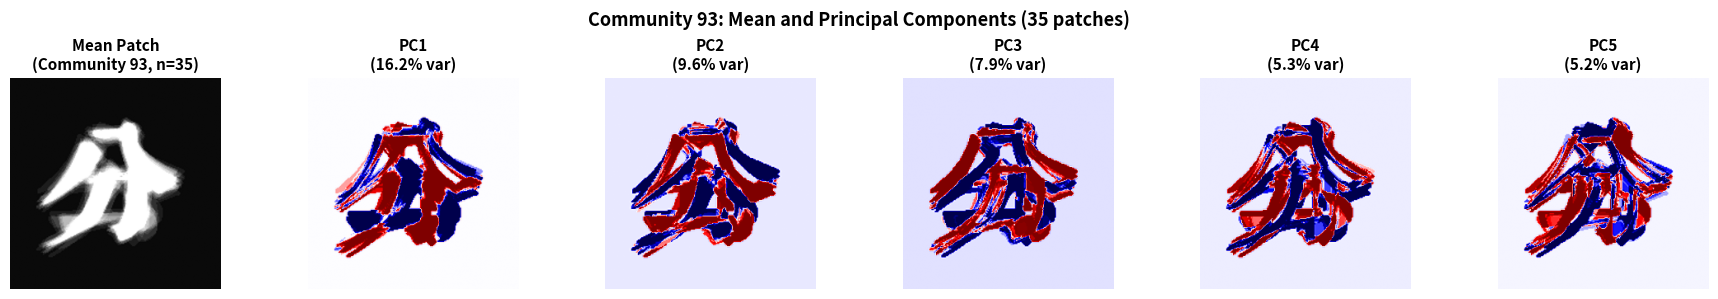

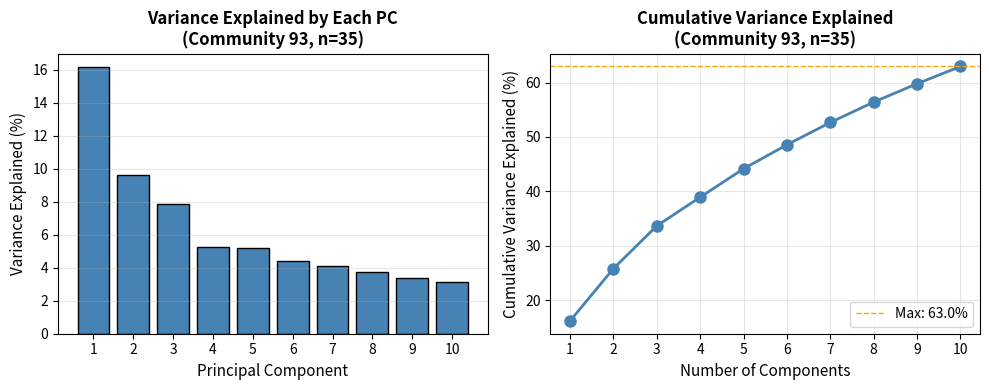

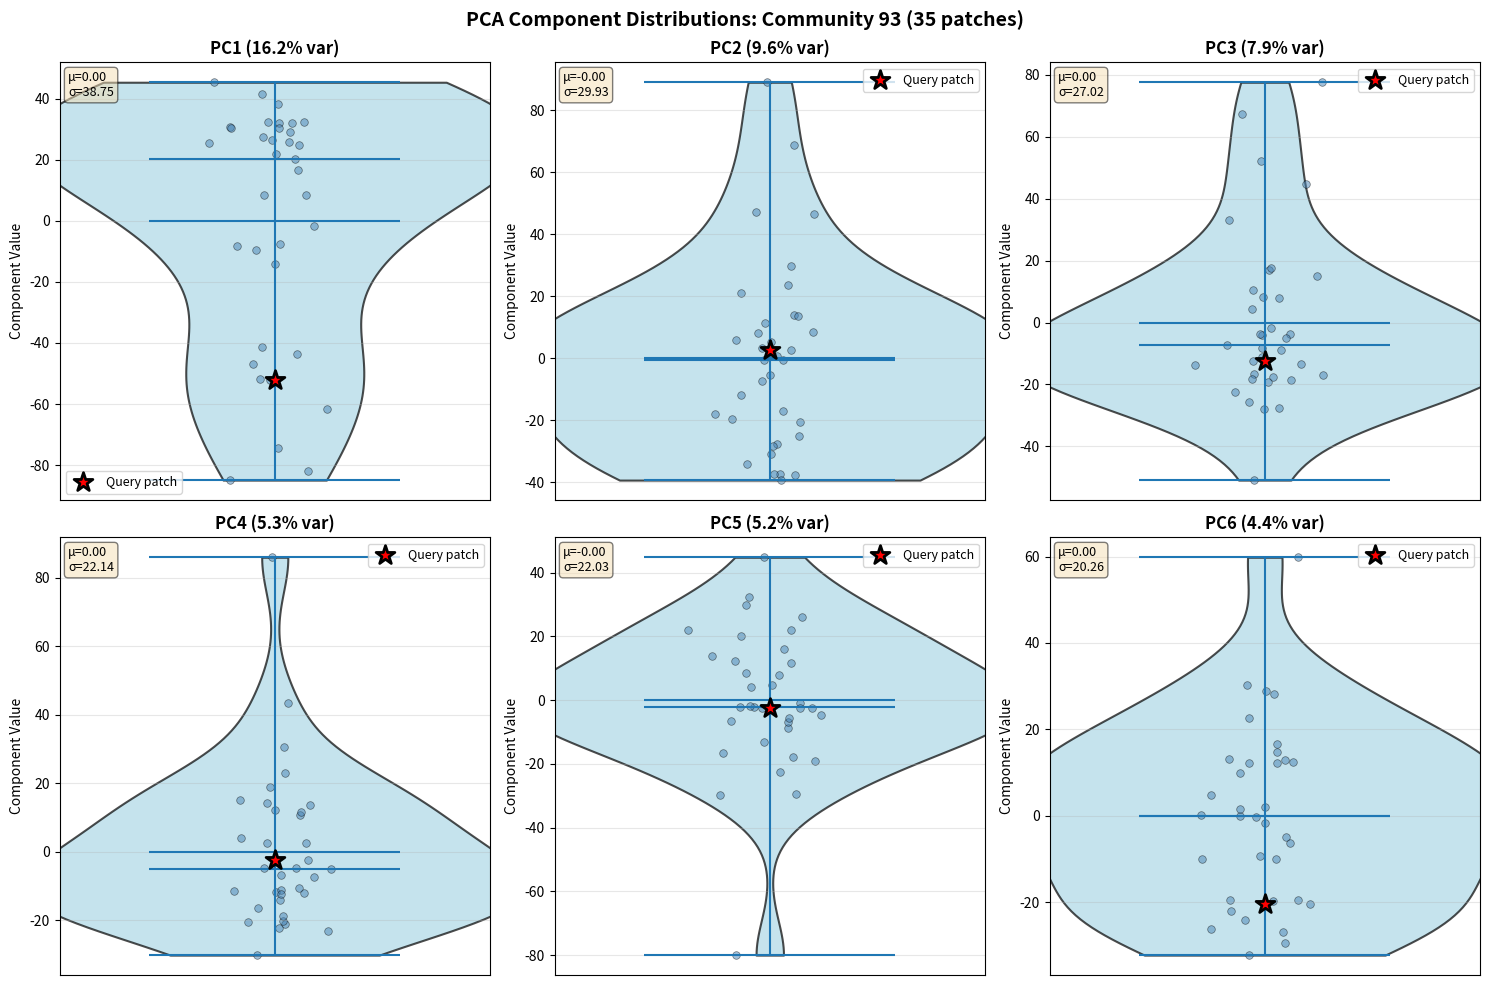

PCA Analysis:
  - Total variance explained by 10 components: 63.0%
  - Note: Only 63.0% variance achievable with 10 components


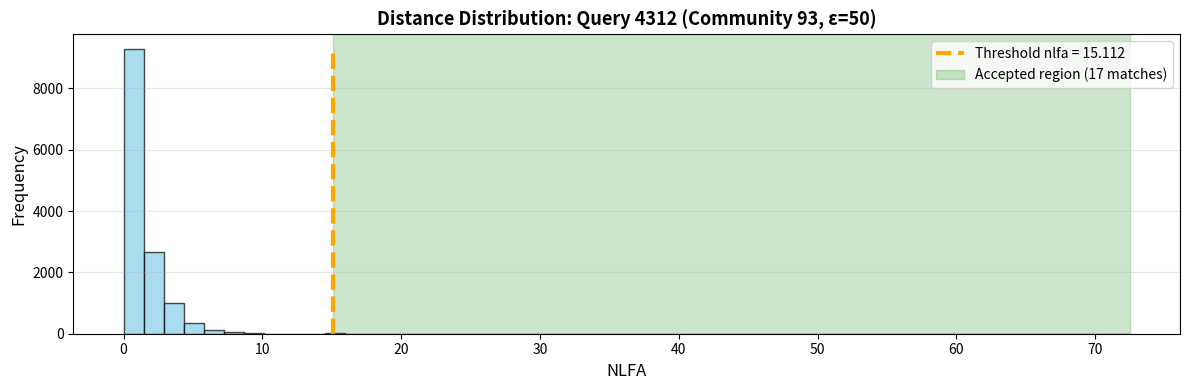

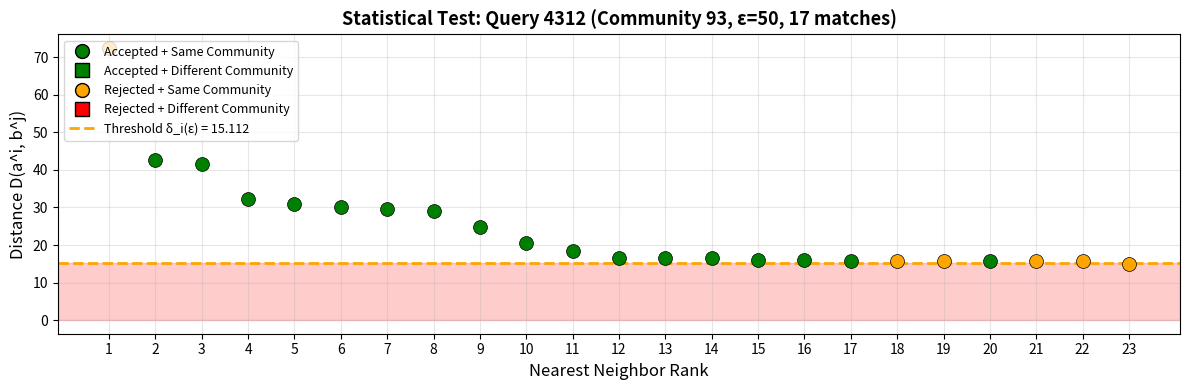

/home/mathis/Bureau/OCRProject/notebook_utils/community_analysis.py:613: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Noto Sans CJK JP.
  plt.tight_layout()
/home/mathis/anaconda3/envs/projetOCR/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Noto Sans CJK JP.
  fig.canvas.print_figure(bytes_io, **kw)


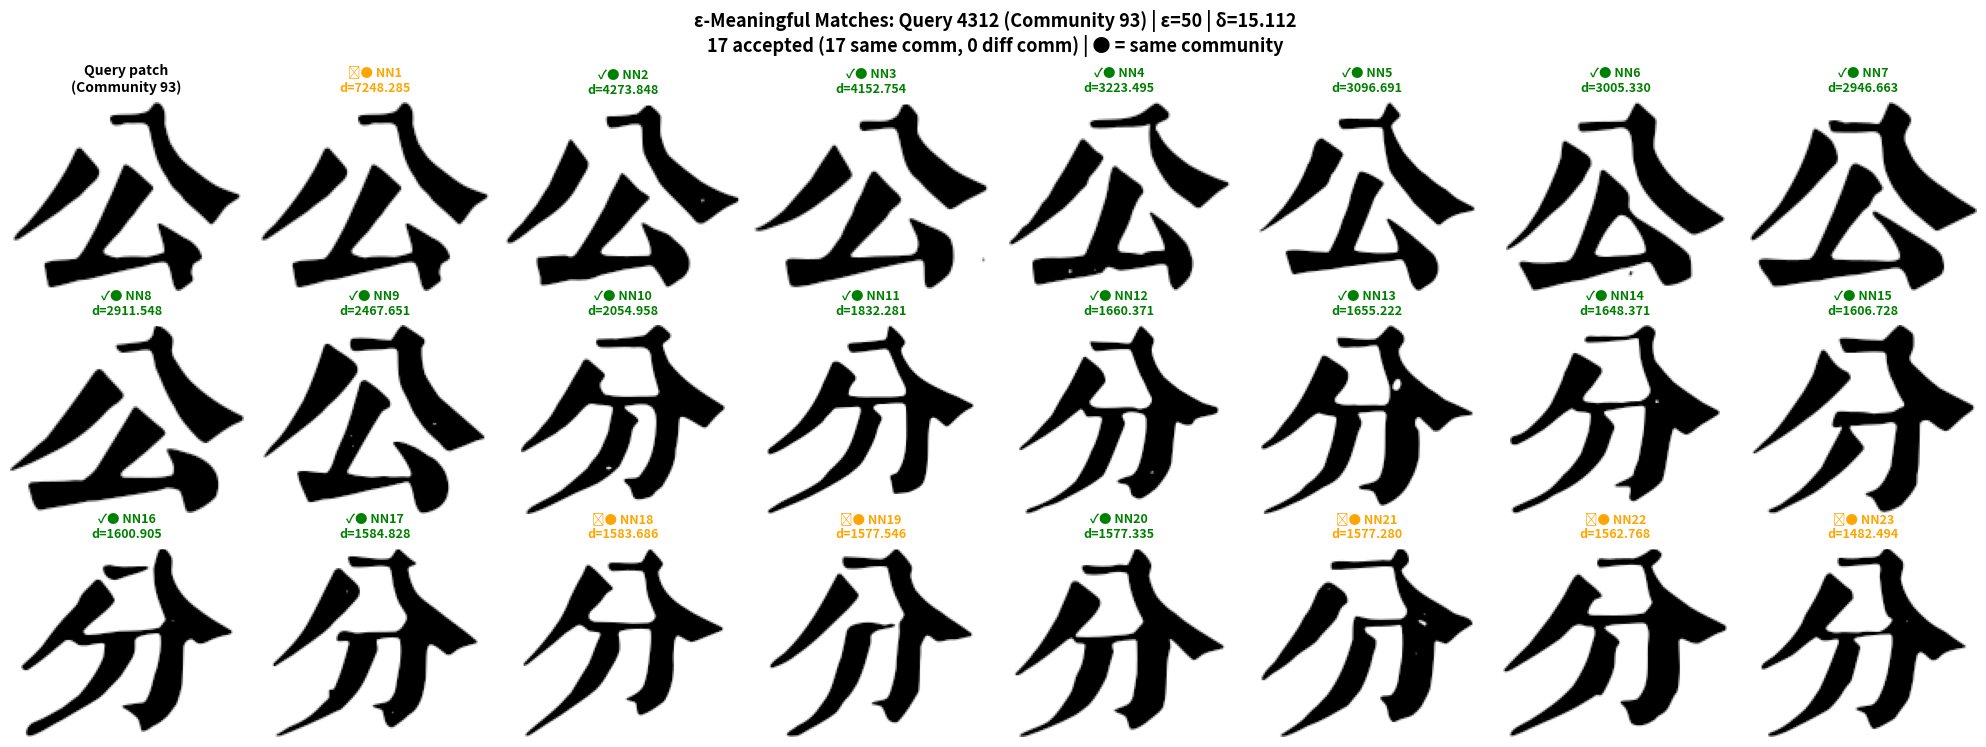


Query Patch 4312 - Community 93
Total community size: 35
Total accepted matches: 17
  - Same community: 17
  - Different community: 0
Among top 23 nearest neighbors:
  - Same community: 23
  - Different community: 0


In [ ]:
from notebook_utils.community_analysis import analyze_community_patch

# Pick a random query
i = np.random.randint(0, len(patches_df['svg']))

# Analyze a specific query patch
results = analyze_community_patch(
    query_idx=i,  # or any patch index
    patches_df=patches_df,
    dataset=dataset,
    communities=communities,
    match_indices=matches,
    nlfa=nlfa,
    nlfa_threshold=nlfa_threshold,
    eps=eps,
    torch_to_pil=torch_to_pil,
)


**We export the results like this:**

In [27]:
from notebook_utils.parquet_utils import save_dataframe
save_dataframe(patches_df, 'data/processed/book1_columnwise_comm')

Saving column: bin_patch
Saving column: img_patch
Saving column: page
Saving column: file
Saving column: left
Saving column: top
Saving column: width
Saving column: height
Saving column: svg
Saving column: aspect_ratio
Saving column: predicted_char
Saving column: histogram
Saving column: community
✓ Saved to data/processed/book1_columnwise_comm


**These are useful graph metrics that we would like to keep a trace of:**

In [28]:
stats = {
    'Modularity' : nx.community.modularity(G, communities),
    'Density': nx.density(G)
}
stats

{'Modularity': 0.24095530011335436, 'Density': 0.004608802890237245}

In [36]:
len(np.unique(patches_df['community']))

3509

**High modularity means the graph is well clustered, but is not a perfect indicator for our task.**

A much better indicator is the adjusted_rand_score, which ranges from -1 to 1 and is a measure of how aligned our clustering is compared to the (noisy) labels from the OCR model used to detect the characters. All of these metrics should be logged.

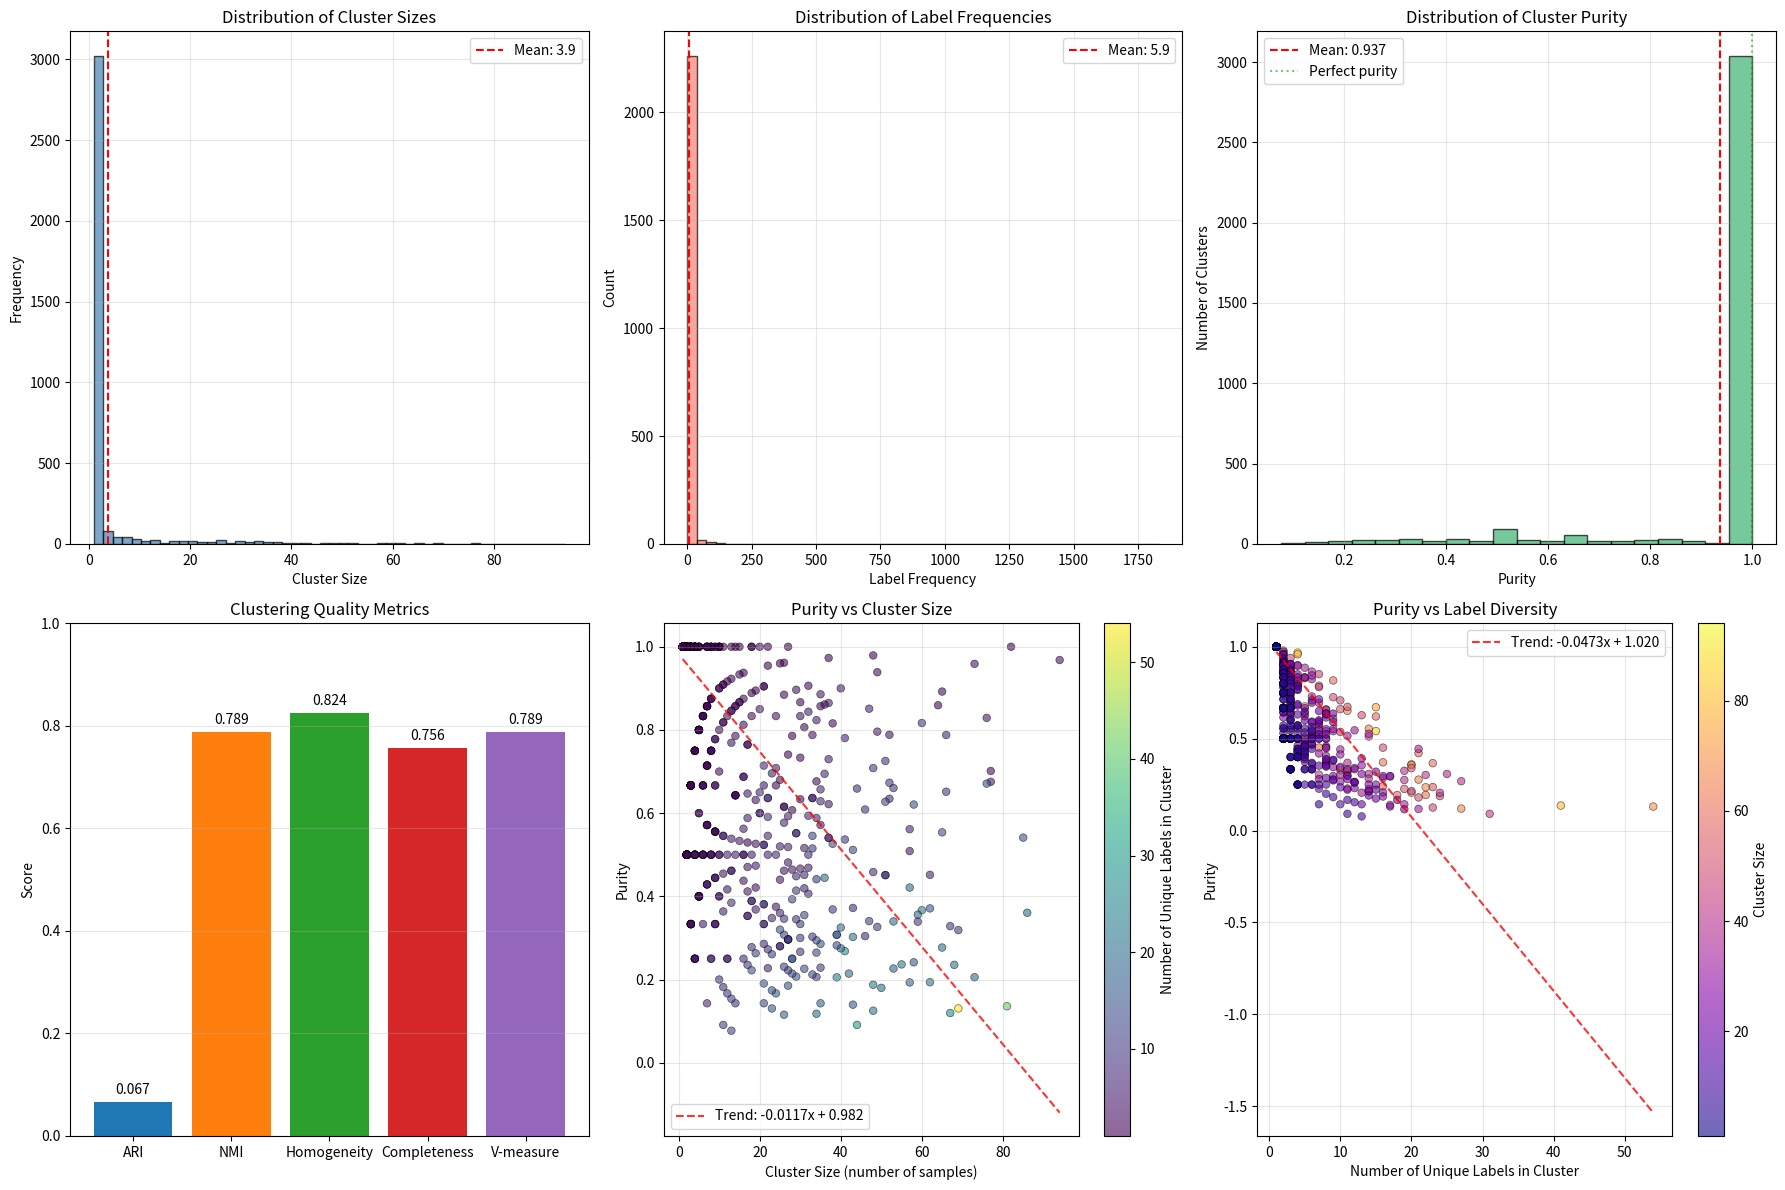


# Clustering vs Labels Analysis Report

**Dataset Statistics:**
- Total samples: **13,519**
- Unique labels: **2,299**
- Unique clusters: **3,509**
- Average cluster size: **3.9**
- Average label frequency: **5.9**

---

## 📊 Clustering Quality Metrics

| Metric | Score | Explanation |
|--------|-------|-------------|
| **Adjusted Rand Index (ARI)** | **0.0665** | Measures similarity between two data clusterings, adjusted for chance. Range: -1 to 1, where 1 = perfect match, 0 = random labeling, negative = worse than random. |
| **Normalized Mutual Info (NMI)** | **0.7889** | Measures mutual dependence between two clusterings, normalized to 0-1 scale. 1 = perfect correlation, 0 = independent. |
| **Homogeneity Score** | **0.8243** | Each cluster contains only members of a single class. 1 = perfect homogeneity, 0 = clusters contain mixed classes. |
| **Completeness Score** | **0.7564** | All members of a given class are assigned to the same cluster. 1 = perfect completeness, 0 = class members split across clusters. |
| **V-measure Score** | **0.7889** | Harmonic mean of homogeneity and completeness. Balanced measure of both aspects. |

---

## 📈 Distribution Statistics

**Cluster Size Distribution:**
- Min: **1** samples
- Max: **94** samples  
- Mean: **3.9** samples
- Median: **1.0** samples
- Standard deviation: **9.9**

**Label Frequency Distribution:**
- Min: **1** occurrences
- Max: **1,830** occurrences
- Mean: **5.9** occurrences
- Median: **2.0** occurrences

**Purity Statistics:**
- Overall average purity: **0.937**
- Perfect purity clusters (1.0): **3,032** (86.4%)
- High purity clusters (≥0.9): **3,052** (87.0%)
- Medium purity clusters (0.7-0.9): **95** (2.7%)
- Low purity clusters (0.5-0.7): **188** (5.4%)
- Poor purity clusters (<0.5): **174** (5.0%)

**Correlation Analysis:**
- Size-Purity correlation: **-0.652** (negative relationship)

---

## 🔍 Purity vs Cluster Size Analysis

**Key Insights from the Scatter Plot:**

1. **Purity Distribution**: Shows how pure each cluster is (percentage of dominant label).
2. **Size Impact**: Larger clusters tend to be less pure.
3. **Color Coding**: Points are colored by number of unique labels in the cluster (darker = more diverse labels).
4. **Ideal Clusters**: Points in the top-left are small but pure; points in the top-right are large and pure.

**Interpretation of Correlation (-0.652):**
- **Positive (> 0.3)**: Larger clusters tend to be more pure
- **Near zero (-0.1 to 0.1)**: No relationship between size and purity
- **Negative (< -0.3)**: Smaller clusters tend to be more pure

---

## 🔍 Interpretation Guide

**ARI Score (0.067):**
- **> 0.7**: Excellent agreement
- **0.5 - 0.7**: Good agreement  
- **0.3 - 0.5**: Moderate agreement
- **0.1 - 0.3**: Weak agreement
- **< 0.1**: Essentially random

**NMI Score (0.789):**
- **> 0.8**: Strong relationship
- **0.5 - 0.8**: Moderate relationship
- **< 0.5**: Weak relationship

**Purity Guidelines:**
- **> 0.9**: Excellent - Cluster is dominated by one label
- **0.7 - 0.9**: Good - Clear dominant label
- **0.5 - 0.7**: Fair - Some mixing but dominant label exists
- **< 0.5**: Poor - No clear dominant label

**Homogeneity vs Completeness:**
- High homogeneity + Low completeness: Labels are split across clusters
- Low homogeneity + High completeness: Clusters contain multiple labels
- Both high: Good clustering structure
- Both low: Poor clustering structure



DETAILED CLUSTER ANALYSIS

Top 10 Clusters by Purity:
 Cluster  Size  Purity  Unique_Labels Dominant_Label
       3    82     1.0              1              有
     155    27     1.0              1               
     192    22     1.0              1              萬
     210    20     1.0              1              近
     226    18     1.0              1              我
     227    18     1.0              1              理
     251    15     1.0              1              言
     261    14     1.0              1              武
     272    13     1.0              1              直
     291    11     1.0              1              者

Bottom 10 Clusters by Purity:
 Cluster  Size   Purity  Unique_Labels Dominant_Label
     266    13 0.076923             13              稱
      59    44 0.090909             31              封
     285    11 0.090909             11              其
     157    26 0.115385             19              西
      96    34 0.117647             21              裡
      1

In [33]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate metrics
ari_score = adjusted_rand_score(patches_df['predicted_char'], patches_df['community'])
nmi_score = normalized_mutual_info_score(patches_df['predicted_char'], patches_df['community'])
homogeneity = homogeneity_score(patches_df['predicted_char'], patches_df['community'])
completeness = completeness_score(patches_df['predicted_char'], patches_df['community'])
v_measure = v_measure_score(patches_df['predicted_char'], patches_df['community'])

# Calculate purity for all clusters
cluster_sizes = patches_df['community'].value_counts()
purity_data = []

for cluster in cluster_sizes.index:
    cluster_data = patches_df[patches_df['community'] == cluster]
    cluster_size = len(cluster_data)
    label_counts = cluster_data['predicted_char'].value_counts()
    purity = label_counts.iloc[0] / cluster_size  # Dominant label percentage
    purity_data.append({
        'Cluster': cluster,
        'Size': cluster_size,
        'Purity': purity,
        'Dominant_Label': label_counts.index[0],
        'Unique_Labels': len(label_counts)
    })

purity_df = pd.DataFrame(purity_data)

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Cluster size distribution
axes[0, 0].hist(cluster_sizes.values, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 0].axvline(cluster_sizes.mean(), color='red', linestyle='--', 
                   label=f'Mean: {cluster_sizes.mean():.1f}')
axes[0, 0].set_xlabel('Cluster Size')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Cluster Sizes')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Label frequency distribution
label_sizes = patches_df['predicted_char'].value_counts()
axes[0, 1].hist(label_sizes.values, bins=50, alpha=0.7, color='salmon', edgecolor='black')
axes[0, 1].axvline(label_sizes.mean(), color='red', linestyle='--', 
                   label=f'Mean: {label_sizes.mean():.1f}')
axes[0, 1].set_xlabel('Label Frequency')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Distribution of Label Frequencies')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Purity distribution
axes[0, 2].hist(purity_df['Purity'], bins=20, alpha=0.7, color='mediumseagreen', edgecolor='black')
axes[0, 2].axvline(purity_df['Purity'].mean(), color='red', linestyle='--',
                   label=f'Mean: {purity_df["Purity"].mean():.3f}')
axes[0, 2].axvline(1.0, color='green', linestyle=':', alpha=0.5, label='Perfect purity')
axes[0, 2].set_xlabel('Purity')
axes[0, 2].set_ylabel('Number of Clusters')
axes[0, 2].set_title('Distribution of Cluster Purity')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Metric comparison bar chart
metrics = ['ARI', 'NMI', 'Homogeneity', 'Completeness', 'V-measure']
values = [ari_score, nmi_score, homogeneity, completeness, v_measure]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

bars = axes[1, 0].bar(metrics, values, color=colors)
axes[1, 0].set_ylim(0, 1.0)
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Clustering Quality Metrics')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=10)

# 5. Purity vs Cluster Size (scatter plot)
scatter = axes[1, 1].scatter(purity_df['Size'], purity_df['Purity'], 
                            alpha=0.6, c=purity_df['Unique_Labels'], 
                            cmap='viridis', edgecolors='black', linewidth=0.5, s=30)
axes[1, 1].set_xlabel('Cluster Size (number of samples)')
axes[1, 1].set_ylabel('Purity')
axes[1, 1].set_title('Purity vs Cluster Size')
axes[1, 1].grid(True, alpha=0.3)

# Add colorbar for number of unique labels
cbar = plt.colorbar(scatter, ax=axes[1, 1])
cbar.set_label('Number of Unique Labels in Cluster')

# Add trend line if there's enough data
if len(purity_df) > 10:
    z = np.polyfit(purity_df['Size'], purity_df['Purity'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(purity_df['Size'].min(), purity_df['Size'].max(), 100)
    axes[1, 1].plot(x_line, p(x_line), "r--", alpha=0.8, 
                   label=f'Trend: {z[0]:.4f}x + {z[1]:.3f}')
    axes[1, 1].legend()

# 6. Purity vs Unique Labels
scatter2 = axes[1, 2].scatter(purity_df['Unique_Labels'], purity_df['Purity'],
                             alpha=0.6, c=purity_df['Size'], 
                             cmap='plasma', edgecolors='black', linewidth=0.5, s=30)
axes[1, 2].set_xlabel('Number of Unique Labels in Cluster')
axes[1, 2].set_ylabel('Purity')
axes[1, 2].set_title('Purity vs Label Diversity')
axes[1, 2].grid(True, alpha=0.3)

# Add colorbar for cluster size
cbar2 = plt.colorbar(scatter2, ax=axes[1, 2])
cbar2.set_label('Cluster Size')

# Add trend line
if len(purity_df) > 10:
    z2 = np.polyfit(purity_df['Unique_Labels'], purity_df['Purity'], 1)
    p2 = np.poly1d(z2)
    x_line2 = np.linspace(purity_df['Unique_Labels'].min(), purity_df['Unique_Labels'].max(), 100)
    axes[1, 2].plot(x_line2, p2(x_line2), "r--", alpha=0.8,
                   label=f'Trend: {z2[0]:.4f}x + {z2[1]:.3f}')
    axes[1, 2].legend()

plt.tight_layout()
plt.show()

# Now display Markdown explanations
from IPython.display import display, Markdown

# Calculate additional statistics
perfect_purity = (purity_df['Purity'] == 1.0).sum()
high_purity = (purity_df['Purity'] >= 0.9).sum()
medium_purity = ((purity_df['Purity'] >= 0.7) & (purity_df['Purity'] < 0.9)).sum()
low_purity = ((purity_df['Purity'] >= 0.5) & (purity_df['Purity'] < 0.7)).sum()
poor_purity = (purity_df['Purity'] < 0.5).sum()

# Correlation between size and purity
correlation = purity_df['Size'].corr(purity_df['Purity'])

markdown_report = f"""
# Clustering vs Labels Analysis Report

**Dataset Statistics:**
- Total samples: **{len(patches_df):,}**
- Unique labels: **{patches_df['predicted_char'].nunique():,}**
- Unique clusters: **{patches_df['community'].nunique():,}**
- Average cluster size: **{len(patches_df)/patches_df['community'].nunique():.1f}**
- Average label frequency: **{len(patches_df)/patches_df['predicted_char'].nunique():.1f}**

---

## 📊 Clustering Quality Metrics

| Metric | Score | Explanation |
|--------|-------|-------------|
| **Adjusted Rand Index (ARI)** | **{ari_score:.4f}** | Measures similarity between two data clusterings, adjusted for chance. Range: -1 to 1, where 1 = perfect match, 0 = random labeling, negative = worse than random. |
| **Normalized Mutual Info (NMI)** | **{nmi_score:.4f}** | Measures mutual dependence between two clusterings, normalized to 0-1 scale. 1 = perfect correlation, 0 = independent. |
| **Homogeneity Score** | **{homogeneity:.4f}** | Each cluster contains only members of a single class. 1 = perfect homogeneity, 0 = clusters contain mixed classes. |
| **Completeness Score** | **{completeness:.4f}** | All members of a given class are assigned to the same cluster. 1 = perfect completeness, 0 = class members split across clusters. |
| **V-measure Score** | **{v_measure:.4f}** | Harmonic mean of homogeneity and completeness. Balanced measure of both aspects. |

---

## 📈 Distribution Statistics

**Cluster Size Distribution:**
- Min: **{cluster_sizes.min():,}** samples
- Max: **{cluster_sizes.max():,}** samples  
- Mean: **{cluster_sizes.mean():.1f}** samples
- Median: **{cluster_sizes.median():.1f}** samples
- Standard deviation: **{cluster_sizes.std():.1f}**

**Label Frequency Distribution:**
- Min: **{label_sizes.min():,}** occurrences
- Max: **{label_sizes.max():,}** occurrences
- Mean: **{label_sizes.mean():.1f}** occurrences
- Median: **{label_sizes.median():.1f}** occurrences

**Purity Statistics:**
- Overall average purity: **{purity_df["Purity"].mean():.3f}**
- Perfect purity clusters (1.0): **{perfect_purity:,}** ({perfect_purity/len(purity_df)*100:.1f}%)
- High purity clusters (≥0.9): **{high_purity:,}** ({high_purity/len(purity_df)*100:.1f}%)
- Medium purity clusters (0.7-0.9): **{medium_purity:,}** ({medium_purity/len(purity_df)*100:.1f}%)
- Low purity clusters (0.5-0.7): **{low_purity:,}** ({low_purity/len(purity_df)*100:.1f}%)
- Poor purity clusters (<0.5): **{poor_purity:,}** ({poor_purity/len(purity_df)*100:.1f}%)

**Correlation Analysis:**
- Size-Purity correlation: **{correlation:.3f}** ({'positive' if correlation > 0 else 'negative' if correlation < 0 else 'no'} relationship)

---

## 🔍 Purity vs Cluster Size Analysis

**Key Insights from the Scatter Plot:**

1. **Purity Distribution**: Shows how pure each cluster is (percentage of dominant label).
2. **Size Impact**: Larger clusters tend to be {'more pure' if correlation > 0.1 else 'less pure' if correlation < -0.1 else 'equally pure regardless of size'}.
3. **Color Coding**: Points are colored by number of unique labels in the cluster (darker = more diverse labels).
4. **Ideal Clusters**: Points in the top-left are small but pure; points in the top-right are large and pure.

**Interpretation of Correlation ({correlation:.3f}):**
- **Positive (> 0.3)**: Larger clusters tend to be more pure
- **Near zero (-0.1 to 0.1)**: No relationship between size and purity
- **Negative (< -0.3)**: Smaller clusters tend to be more pure

---

## 🔍 Interpretation Guide

**ARI Score ({ari_score:.3f}):**
- **> 0.7**: Excellent agreement
- **0.5 - 0.7**: Good agreement  
- **0.3 - 0.5**: Moderate agreement
- **0.1 - 0.3**: Weak agreement
- **< 0.1**: Essentially random

**NMI Score ({nmi_score:.3f}):**
- **> 0.8**: Strong relationship
- **0.5 - 0.8**: Moderate relationship
- **< 0.5**: Weak relationship

**Purity Guidelines:**
- **> 0.9**: Excellent - Cluster is dominated by one label
- **0.7 - 0.9**: Good - Clear dominant label
- **0.5 - 0.7**: Fair - Some mixing but dominant label exists
- **< 0.5**: Poor - No clear dominant label

**Homogeneity vs Completeness:**
- High homogeneity + Low completeness: Labels are split across clusters
- Low homogeneity + High completeness: Clusters contain multiple labels
- Both high: Good clustering structure
- Both low: Poor clustering structure
"""

display(Markdown(markdown_report))

# Additional detailed analysis
print("\n" + "="*60)
print("DETAILED CLUSTER ANALYSIS")
print("="*60)

# Top clusters by purity
print(f"\nTop 10 Clusters by Purity:")
top_purity = purity_df.nlargest(10, 'Purity')[['Cluster', 'Size', 'Purity', 'Unique_Labels', 'Dominant_Label']]
print(top_purity.to_string(index=False))

# Bottom clusters by purity
print(f"\nBottom 10 Clusters by Purity:")
bottom_purity = purity_df.nsmallest(10, 'Purity')[['Cluster', 'Size', 'Purity', 'Unique_Labels', 'Dominant_Label']]
print(bottom_purity.to_string(index=False))

# Analyze size-purity relationship
print(f"\nSize-Purity Relationship Analysis:")
print(f"  Correlation coefficient: {correlation:.3f}")
if correlation > 0.3:
    print("  ✓ Strong positive correlation: Larger clusters tend to be more pure")
elif correlation > 0.1:
    print("  ⚠️ Weak positive correlation: Slight tendency for larger clusters to be more pure")
elif correlation < -0.3:
    print("  ✓ Strong negative correlation: Smaller clusters tend to be more pure")
elif correlation < -0.1:
    print("  ⚠️ Weak negative correlation: Slight tendency for smaller clusters to be more pure")
else:
    print("  ○ No clear correlation: Purity is independent of cluster size")

# Statistical breakdown by purity category
print(f"\nPurity Category Breakdown:")
for name, count in [("Perfect (1.0)", perfect_purity),
                   ("High (≥0.9)", high_purity),
                   ("Medium (0.7-0.9)", medium_purity),
                   ("Low (0.5-0.7)", low_purity),
                   ("Poor (<0.5)", poor_purity)]:
    percentage = count/len(purity_df)*100
    avg_size = purity_df[purity_df['Purity'] >= (1.0 if name.startswith('Perfect') else 
                                                0.9 if name.startswith('High') else
                                                0.7 if name.startswith('Medium') else
                                                0.5 if name.startswith('Low') else 0)]['Size'].mean()
    print(f"  {name}: {count:,} clusters ({percentage:.1f}%), avg size: {avg_size:.1f}")

# return ari_score

**Here, we show the perecentage of isolated characters. You can keep track of this as well.**

In [37]:
# Count isolated characters (community size <= 1)
thresh = 1

# Get community sizes from the dataframe
community_counts = patches_df['community'].value_counts()

# Count patches in small communities
n_hapax = (community_counts[community_counts <= thresh]).sum()
total = len(patches_df)

print(f"{100 * n_hapax / total:.3f}% d'hapax ({n_hapax}/{total} patches)")

21.562% d'hapax (2915/13519 patches)


In [9]:

plt.figure(figsize=(10, 4))
plt.hist(community_counts, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Number of characters per community', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Community Sizes', fontsize=13, fontweight='bold')
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"Total communities: {len(community_counts)}")
print(f"Mean size: {community_counts.mean():.2f}")
print(f"Median size: {community_counts.median():.0f}")
print(f"Max size: {community_counts.max()}")

NameError: name 'community_counts' is not defined

<Figure size 1000x400 with 0 Axes>

In [ ]:
%matplotlib tk


Showing community 0: 154 nodes
Computing t-SNE layout...


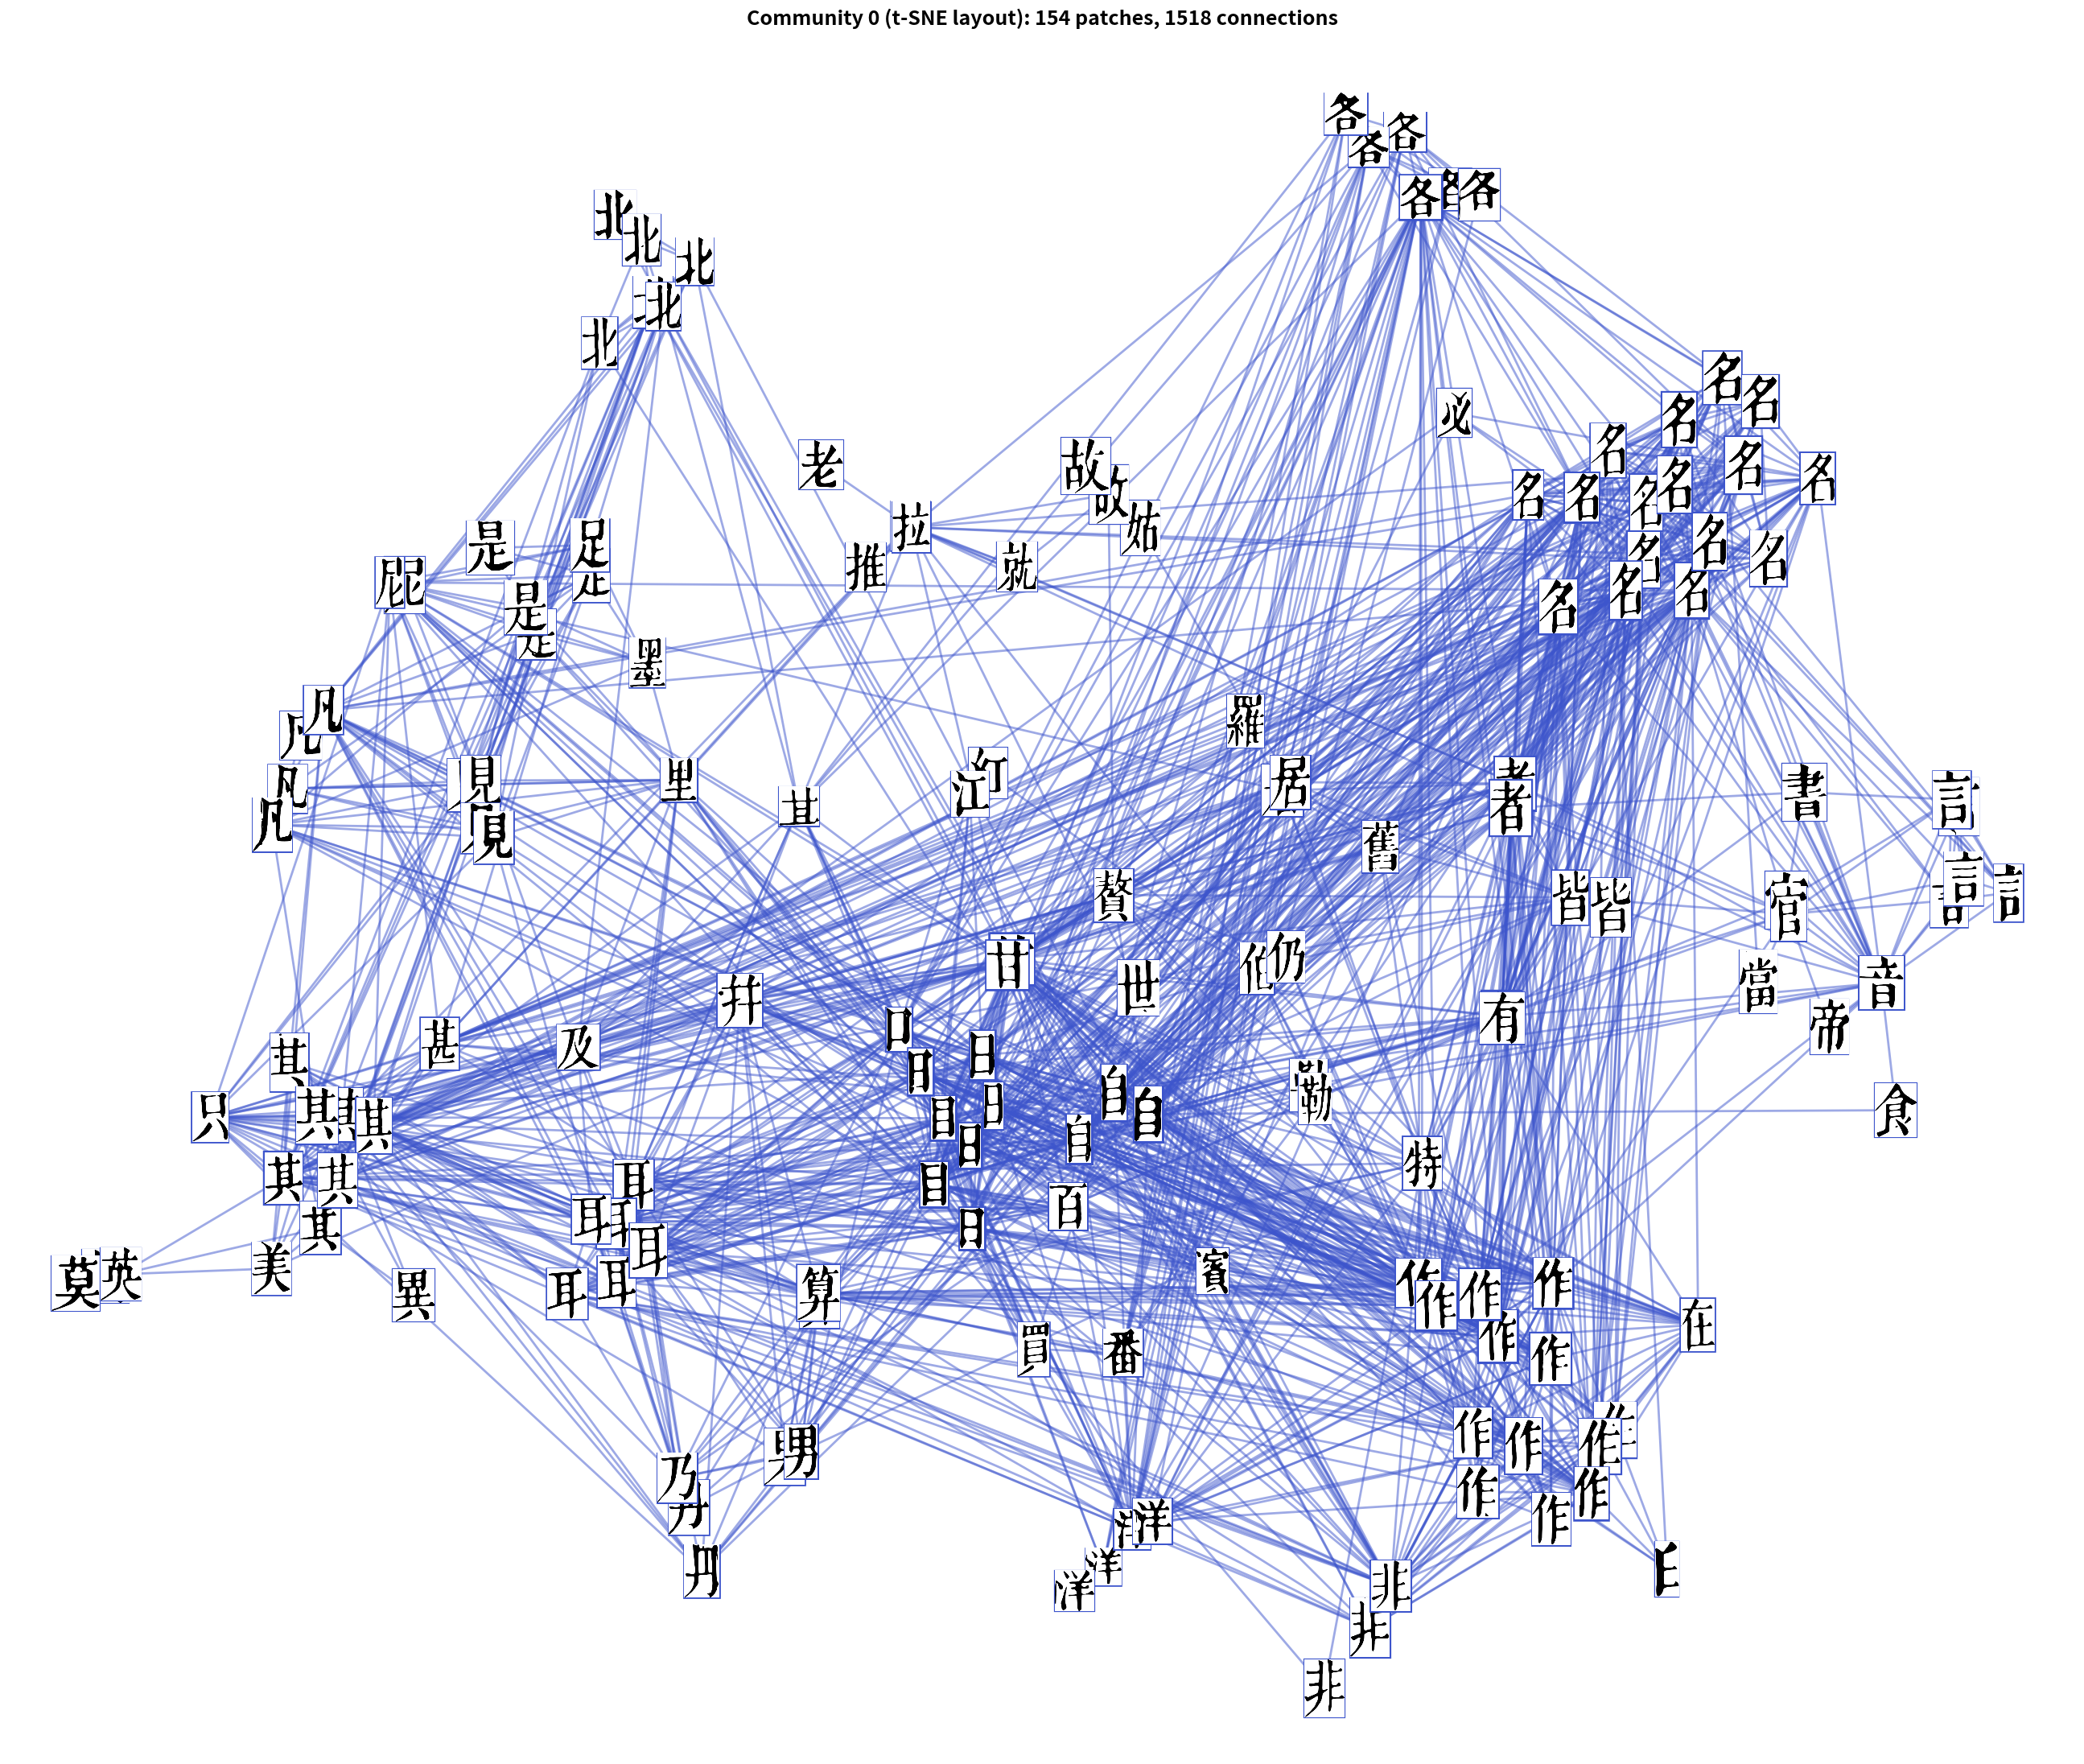

✓ Visualization complete


In [ ]:
COMMUNITY_TO_SHOW = 0

import random
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import gc


selected_comm_idx = COMMUNITY_TO_SHOW
size = len(communities[selected_comm_idx])

selected_nodes = list(communities[selected_comm_idx])

print(f"\nShowing community {selected_comm_idx}: {len(selected_nodes)} nodes")

# Create subgraph
G_sub = G.subgraph(selected_nodes).copy()

# ============================================
# t-SNE LAYOUT (instead of spring layout)
# ============================================

print("Computing t-SNE layout...")

# Get the feature vectors for selected nodes
X_selected = histograms.reshape(histograms.shape[0], -1)[selected_nodes].cpu().numpy()

# Compute t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(selected_nodes)-1))
tsne_coords = tsne.fit_transform(X_selected)

# Scale to similar range as before (optional, for similar visualization size)
tsne_coords = tsne_coords * 20 / tsne_coords.std()

# Create position dictionary
pos = {node: tsne_coords[i] for i, node in enumerate(selected_nodes)}
coords = tsne_coords

# ============================================
# Visualization
# ============================================

# Adjust display size
N_sub = len(selected_nodes)
if N_sub < 50:
    display_size, zoom = 64, 1.2
elif N_sub < 200:
    display_size, zoom = 48, 0.9
elif N_sub < 500:
    display_size, zoom = 32, 0.7
else:
    display_size, zoom = 24, 0.5

zoom /= 4

# Create figure
fig, ax = plt.subplots(figsize=(26, 22), dpi=100)

# Generate community color
random.seed(42 + selected_comm_idx)
hue = random.random()
import colorsys
r, g, b = colorsys.hsv_to_rgb(hue, 0.7, 0.8)
community_color = [r, g, b, 1.0]

# Draw edges
for i, j in G_sub.edges():
    i_idx = selected_nodes.index(i)
    j_idx = selected_nodes.index(j)
    ax.plot([coords[i_idx, 0], coords[j_idx, 0]], 
        [coords[i_idx, 1], coords[j_idx, 1]], 
        color=community_color, alpha=0.5, linewidth=2.0, zorder=1)

# Draw nodes with patches
degrees_sub = np.array([G_sub.degree(node) for node in selected_nodes])

for idx, node in enumerate(selected_nodes):
    patch = patches_df['svg'][node].render(scale=2)
    pil_img = Image.fromarray(patch)
    
    imagebox = OffsetImage(pil_img, zoom=zoom, cmap='gray')
    
    # Border width by degree
    if degrees_sub.max() > 0:
        border_width = 1.5 + 2.5 * (degrees_sub[idx] / degrees_sub.max())
    else:
        border_width = 1.5
    
    ab = AnnotationBbox(
        imagebox, 
        (coords[idx, 0], coords[idx, 1]),
        frameon=True,
        pad=0.0,
        bboxprops=dict(
            edgecolor=community_color,
            linewidth=border_width,
            facecolor='white',
            alpha=1.0
        ),
        zorder=10
    )
    ax.add_artist(ab)

# Finalize plot
margin = 3
ax.set_xlim(coords[:, 0].min() - margin, coords[:, 0].max() + margin)
ax.set_ylim(coords[:, 1].min() - margin, coords[:, 1].max() + margin)
ax.set_aspect('equal')
ax.axis('off')

ax.set_title(f'Community {selected_comm_idx} (t-SNE layout): {N_sub} patches, {G_sub.number_of_edges()} connections', 
            fontsize=18, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print(f"✓ Visualization complete")


In [ ]:
community_sizes

[(0, 114),
 (1, 114),
 (2, 110),
 (3, 110),
 (4, 105),
 (5, 97),
 (6, 95),
 (7, 91),
 (8, 91),
 (9, 90),
 (10, 89),
 (11, 87),
 (12, 85),
 (13, 82),
 (14, 76),
 (15, 76),
 (16, 75),
 (17, 73),
 (18, 72),
 (19, 67),
 (20, 67),
 (21, 67),
 (22, 66),
 (23, 66),
 (24, 65),
 (25, 64),
 (26, 64),
 (27, 60),
 (28, 58),
 (29, 58),
 (30, 58),
 (31, 55),
 (32, 52),
 (33, 51),
 (34, 51),
 (35, 51),
 (36, 50),
 (37, 50),
 (38, 49),
 (39, 49),
 (40, 45),
 (41, 44),
 (42, 44),
 (43, 43),
 (44, 42),
 (45, 42),
 (46, 42),
 (47, 42),
 (48, 41),
 (49, 41),
 (50, 40),
 (51, 40),
 (52, 40),
 (53, 38),
 (54, 38),
 (55, 38),
 (56, 37),
 (57, 37),
 (58, 37),
 (59, 36),
 (60, 36),
 (61, 36),
 (62, 35),
 (63, 35),
 (64, 35),
 (65, 35),
 (66, 34),
 (67, 34),
 (68, 33),
 (69, 33),
 (70, 32),
 (71, 32),
 (72, 32),
 (73, 32),
 (74, 32),
 (75, 32),
 (76, 32),
 (77, 31),
 (78, 31),
 (79, 31),
 (80, 31),
 (81, 31),
 (82, 30),
 (83, 30),
 (84, 30),
 (85, 30),
 (86, 29),
 (87, 29),
 (88, 29),
 (89, 29),
 (90, 29),
 (91

In [ ]:
import random
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import gc
from tqdm import tqdm

# Sort communities by size
community_sizes = [(i, len(comm)) for i, comm in enumerate(communities)]
community_sizes.sort(key=lambda x: x[1], reverse=True)
community_sizes = list(filter(lambda x: x[1] > 20, community_sizes))

for selected_comm_idx, size in tqdm(community_sizes):

    savepath = Path('saved_figures/graphs2/')
    savepath.mkdir(parents=True, exist_ok=True)
    savepath = savepath / f'{selected_comm_idx}-{size}.png'

    selected_nodes = list(communities[selected_comm_idx])

    print(f"\nShowing community {selected_comm_idx}: {len(selected_nodes)} nodes")

    # Create subgraph
    G_sub = G.subgraph(selected_nodes).copy()

    # ============================================
    # t-SNE LAYOUT (instead of spring layout)
    # ============================================

    print("Computing t-SNE layout...")

    # Get the feature vectors for selected nodes
    X_selected = histograms.reshape(histograms.shape[0], -1)[selected_nodes].cpu().numpy()

    # Compute t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(selected_nodes)-1))
    tsne_coords = tsne.fit_transform(X_selected)

    # Scale to similar range as before (optional, for similar visualization size)
    tsne_coords = tsne_coords * 20 / tsne_coords.std()

    # Create position dictionary
    pos = {node: tsne_coords[i] for i, node in enumerate(selected_nodes)}
    coords = tsne_coords

    # ============================================
    # Visualization
    # ============================================

    # Adjust display size
    N_sub = len(selected_nodes)
    if N_sub < 50:
        display_size, zoom = 64, 1.2
    elif N_sub < 200:
        display_size, zoom = 48, 0.9
    elif N_sub < 500:
        display_size, zoom = 32, 0.7
    else:
        display_size, zoom = 24, 0.5

    zoom /= 4

    # Create figure
    fig, ax = plt.subplots(figsize=(26, 22), dpi=100)

    # Generate community color
    random.seed(42 + selected_comm_idx)
    hue = random.random()
    import colorsys
    r, g, b = colorsys.hsv_to_rgb(hue, 0.7, 0.8)
    community_color = [r, g, b, 1.0]

    # Draw edges
    for i, j in G_sub.edges():
        i_idx = selected_nodes.index(i)
        j_idx = selected_nodes.index(j)
        ax.plot([coords[i_idx, 0], coords[j_idx, 0]], 
            [coords[i_idx, 1], coords[j_idx, 1]], 
            color=community_color, alpha=0.5, linewidth=2.0, zorder=1)

    # Draw nodes with patches
    degrees_sub = np.array([G_sub.degree(node) for node in selected_nodes])

    for idx, node in enumerate(selected_nodes):
        patch = patches_df['svg'][node].render(scale=2)
        pil_img = Image.fromarray(patch)
        
        imagebox = OffsetImage(pil_img, zoom=zoom, cmap='gray')
        
        # Border width by degree
        if degrees_sub.max() > 0:
            border_width = 1.5 + 2.5 * (degrees_sub[idx] / degrees_sub.max())
        else:
            border_width = 1.5
        
        ab = AnnotationBbox(
            imagebox, 
            (coords[idx, 0], coords[idx, 1]),
            frameon=True,
            pad=0.0,
            bboxprops=dict(
                edgecolor=community_color,
                linewidth=border_width,
                facecolor='white',
                alpha=1.0
            ),
            zorder=10
        )
        ax.add_artist(ab)

    # Finalize plot
    margin = 3
    ax.set_xlim(coords[:, 0].min() - margin, coords[:, 0].max() + margin)
    ax.set_ylim(coords[:, 1].min() - margin, coords[:, 1].max() + margin)
    ax.set_aspect('equal')
    ax.axis('off')

    ax.set_title(f'Community {selected_comm_idx} (t-SNE layout): {N_sub} patches, {G_sub.number_of_edges()} connections', 
                fontsize=18, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.savefig(savepath)
    
    # FIX MEMORY LEAKS: Close figure and clear memory
    plt.close(fig)
    del fig, ax, G_sub, X_selected, tsne, tsne_coords, coords, pil_img
    gc.collect()

    print(f"✓ Visualization complete")

  0%|          | 0/164 [00:00<?, ?it/s]


Showing community 0: 154 nodes
Computing t-SNE layout...


  1%|          | 1/164 [00:03<10:24,  3.83s/it]

✓ Visualization complete

Showing community 1: 117 nodes
Computing t-SNE layout...


  1%|          | 2/164 [00:08<12:01,  4.45s/it]

✓ Visualization complete

Showing community 2: 108 nodes
Computing t-SNE layout...


  2%|▏         | 3/164 [00:11<10:07,  3.77s/it]

✓ Visualization complete

Showing community 3: 97 nodes
Computing t-SNE layout...


  2%|▏         | 4/164 [00:15<10:15,  3.85s/it]

✓ Visualization complete

Showing community 4: 95 nodes
Computing t-SNE layout...


  3%|▎         | 5/164 [00:20<10:45,  4.06s/it]

✓ Visualization complete

Showing community 5: 93 nodes
Computing t-SNE layout...


  4%|▎         | 6/164 [00:24<10:48,  4.10s/it]

✓ Visualization complete

Showing community 6: 92 nodes
Computing t-SNE layout...


  4%|▍         | 7/164 [00:28<11:15,  4.30s/it]

✓ Visualization complete

Showing community 7: 92 nodes
Computing t-SNE layout...


  5%|▍         | 8/164 [00:32<10:54,  4.20s/it]

✓ Visualization complete

Showing community 8: 91 nodes
Computing t-SNE layout...


  5%|▌         | 9/164 [00:36<10:05,  3.91s/it]

✓ Visualization complete

Showing community 9: 90 nodes
Computing t-SNE layout...


  6%|▌         | 10/164 [00:40<10:05,  3.93s/it]

✓ Visualization complete

Showing community 10: 90 nodes
Computing t-SNE layout...


  7%|▋         | 11/164 [00:44<10:25,  4.09s/it]

✓ Visualization complete

Showing community 11: 89 nodes
Computing t-SNE layout...


  7%|▋         | 12/164 [00:49<10:45,  4.25s/it]

✓ Visualization complete

Showing community 12: 87 nodes
Computing t-SNE layout...


  8%|▊         | 13/164 [00:51<09:01,  3.59s/it]

✓ Visualization complete

Showing community 13: 86 nodes
Computing t-SNE layout...


  9%|▊         | 14/164 [00:55<09:14,  3.70s/it]

✓ Visualization complete

Showing community 14: 85 nodes
Computing t-SNE layout...


  9%|▉         | 15/164 [00:58<09:09,  3.69s/it]

✓ Visualization complete

Showing community 15: 82 nodes
Computing t-SNE layout...


 10%|▉         | 16/164 [01:02<09:07,  3.70s/it]

✓ Visualization complete

Showing community 16: 79 nodes
Computing t-SNE layout...


 10%|█         | 17/164 [01:05<08:38,  3.53s/it]

✓ Visualization complete

Showing community 17: 77 nodes
Computing t-SNE layout...


 11%|█         | 18/164 [01:09<08:36,  3.54s/it]

✓ Visualization complete

Showing community 18: 76 nodes
Computing t-SNE layout...


 12%|█▏        | 19/164 [01:12<08:14,  3.41s/it]

✓ Visualization complete

Showing community 19: 74 nodes
Computing t-SNE layout...


 12%|█▏        | 20/164 [01:16<08:22,  3.49s/it]

✓ Visualization complete

Showing community 20: 73 nodes
Computing t-SNE layout...


 13%|█▎        | 21/164 [01:18<07:18,  3.07s/it]

✓ Visualization complete

Showing community 21: 73 nodes
Computing t-SNE layout...


 13%|█▎        | 22/164 [01:21<07:43,  3.26s/it]

✓ Visualization complete

Showing community 22: 72 nodes
Computing t-SNE layout...


 14%|█▍        | 23/164 [01:24<07:27,  3.17s/it]

✓ Visualization complete

Showing community 23: 72 nodes
Computing t-SNE layout...


 15%|█▍        | 24/164 [01:28<07:53,  3.38s/it]

✓ Visualization complete

Showing community 24: 67 nodes
Computing t-SNE layout...


 15%|█▌        | 25/164 [01:31<07:32,  3.26s/it]

✓ Visualization complete

Showing community 25: 66 nodes
Computing t-SNE layout...


 16%|█▌        | 26/164 [01:35<07:36,  3.31s/it]

✓ Visualization complete

Showing community 26: 64 nodes
Computing t-SNE layout...


 16%|█▋        | 27/164 [01:38<07:28,  3.27s/it]

✓ Visualization complete

Showing community 27: 58 nodes
Computing t-SNE layout...


 17%|█▋        | 28/164 [01:41<07:03,  3.12s/it]

✓ Visualization complete

Showing community 28: 58 nodes
Computing t-SNE layout...


 18%|█▊        | 29/164 [01:43<06:25,  2.86s/it]

✓ Visualization complete

Showing community 29: 58 nodes
Computing t-SNE layout...


 18%|█▊        | 30/164 [01:46<06:29,  2.91s/it]

✓ Visualization complete

Showing community 30: 58 nodes
Computing t-SNE layout...


 19%|█▉        | 31/164 [01:49<06:44,  3.04s/it]

✓ Visualization complete

Showing community 31: 56 nodes
Computing t-SNE layout...


 20%|█▉        | 32/164 [01:52<06:23,  2.91s/it]

✓ Visualization complete

Showing community 32: 56 nodes
Computing t-SNE layout...


 20%|██        | 33/164 [01:54<06:10,  2.83s/it]

✓ Visualization complete

Showing community 33: 56 nodes
Computing t-SNE layout...


 21%|██        | 34/164 [01:57<06:00,  2.77s/it]

✓ Visualization complete

Showing community 34: 55 nodes
Computing t-SNE layout...


 21%|██▏       | 35/164 [02:00<05:51,  2.73s/it]

✓ Visualization complete

Showing community 35: 54 nodes
Computing t-SNE layout...


 22%|██▏       | 36/164 [02:02<05:37,  2.64s/it]

✓ Visualization complete

Showing community 36: 54 nodes
Computing t-SNE layout...


 23%|██▎       | 37/164 [02:05<05:35,  2.64s/it]

✓ Visualization complete

Showing community 37: 52 nodes
Computing t-SNE layout...


 23%|██▎       | 38/164 [02:08<05:39,  2.69s/it]

✓ Visualization complete

Showing community 38: 51 nodes
Computing t-SNE layout...


 24%|██▍       | 39/164 [02:10<05:27,  2.62s/it]

✓ Visualization complete

Showing community 39: 51 nodes
Computing t-SNE layout...


 24%|██▍       | 40/164 [02:13<05:35,  2.70s/it]

✓ Visualization complete

Showing community 40: 51 nodes
Computing t-SNE layout...


 25%|██▌       | 41/164 [02:16<05:36,  2.73s/it]

✓ Visualization complete

Showing community 41: 50 nodes
Computing t-SNE layout...


 26%|██▌       | 42/164 [02:18<05:17,  2.61s/it]

✓ Visualization complete

Showing community 42: 49 nodes
Computing t-SNE layout...


 26%|██▌       | 43/164 [02:20<04:59,  2.48s/it]

✓ Visualization complete

Showing community 43: 49 nodes
Computing t-SNE layout...


 27%|██▋       | 44/164 [02:23<04:56,  2.47s/it]

✓ Visualization complete

Showing community 44: 48 nodes
Computing t-SNE layout...


 27%|██▋       | 45/164 [02:25<04:51,  2.45s/it]

✓ Visualization complete

Showing community 45: 47 nodes
Computing t-SNE layout...


 28%|██▊       | 46/164 [02:28<05:04,  2.58s/it]

✓ Visualization complete

Showing community 46: 47 nodes
Computing t-SNE layout...


 29%|██▊       | 47/164 [02:31<05:08,  2.64s/it]

✓ Visualization complete

Showing community 47: 46 nodes
Computing t-SNE layout...


 29%|██▉       | 48/164 [02:33<04:58,  2.57s/it]

✓ Visualization complete

Showing community 48: 46 nodes
Computing t-SNE layout...


 30%|██▉       | 49/164 [02:36<05:05,  2.65s/it]

✓ Visualization complete

Showing community 49: 45 nodes
Computing t-SNE layout...


 30%|███       | 50/164 [02:39<04:56,  2.60s/it]

✓ Visualization complete

Showing community 50: 45 nodes
Computing t-SNE layout...


 31%|███       | 51/164 [02:41<04:52,  2.59s/it]

✓ Visualization complete

Showing community 51: 44 nodes
Computing t-SNE layout...


 32%|███▏      | 52/164 [02:43<04:34,  2.45s/it]

✓ Visualization complete

Showing community 52: 44 nodes
Computing t-SNE layout...


 32%|███▏      | 53/164 [02:46<04:39,  2.52s/it]

✓ Visualization complete

Showing community 53: 43 nodes
Computing t-SNE layout...


 33%|███▎      | 54/164 [02:48<04:35,  2.51s/it]

✓ Visualization complete

Showing community 54: 43 nodes
Computing t-SNE layout...


 34%|███▎      | 55/164 [02:51<04:46,  2.63s/it]

✓ Visualization complete

Showing community 55: 42 nodes
Computing t-SNE layout...


 34%|███▍      | 56/164 [02:54<04:57,  2.75s/it]

✓ Visualization complete

Showing community 56: 42 nodes
Computing t-SNE layout...


In [ ]:
import pandas as pd
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    v_measure_score,
    fowlkes_mallows_score,
    homogeneity_score,
    completeness_score
)

def compare_clustering_to_labels(df, label_col='character', cluster_col='community'):
    """
    Compare clustering results to ground-truth labels.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing both labels and cluster assignments
    label_col : str
        Name of column with ground-truth labels (your classification)
    cluster_col : str
        Name of column with cluster assignments
    
    Returns:
    --------
    dict : Dictionary with all metrics
    """
    
    true_labels = df[label_col]
    cluster_labels = df[cluster_col]
    
    # Compute metrics
    metrics = {
        'Adjusted Rand Index': adjusted_rand_score(true_labels, cluster_labels),
        'Normalized Mutual Information': normalized_mutual_info_score(true_labels, cluster_labels),
        'V-Measure': v_measure_score(true_labels, cluster_labels),
        'Homogeneity': homogeneity_score(true_labels, cluster_labels),
        'Completeness': completeness_score(true_labels, cluster_labels),
        'Fowlkes-Mallows Index': fowlkes_mallows_score(true_labels, cluster_labels)
    }
    
    # Print results
    print("=" * 50)
    print("CLUSTERING EVALUATION METRICS")
    print("=" * 50)
    print(f"Total points: {len(df):,}")
    print(f"Unique characters (true labels): {df[label_col].nunique():,}")
    print(f"Unique communities (clusters): {df[cluster_col].nunique():,}")
    print("=" * 50)
    
    for metric_name, value in metrics.items():
        print(f"{metric_name:.<40} {value:.4f}")
    
    print("=" * 50)
    
    return metrics

metrics = compare_clustering_to_labels(patches_df, label_col='predicted_char', cluster_col='community')



CLUSTERING EVALUATION METRICS
Total points: 3,781
Unique characters (true labels): 1,249
Unique communities (clusters): 1,583
Adjusted Rand Index..................... 0.1064
Normalized Mutual Information........... 0.8860
V-Measure............................... 0.8860
Homogeneity............................. 0.9319
Completeness............................ 0.8444
Fowlkes-Mallows Index................... 0.1895


In [ ]:
comms_to_save = [
    125, 142, 170, 12, 59, 24
]

path = Path('data/extracted/communities_clean/')

for i in comms_to_save:
    idx = communities[i]
    folder = path/f'{i}'
    folder.mkdir(exist_ok=True, parents=True)

    for j in idx:
        svg = patches_df['svg'][j]
        svg.save(folder / f'{j}.svg')


GMM Generation from Community 12
Community size: 53 patches
PCA: 20 components explain 81.6% variance
GMM: fitted with 3 Gaussian components
GMM converged: True, iterations: 2
Generated 12 new samples in PCA space


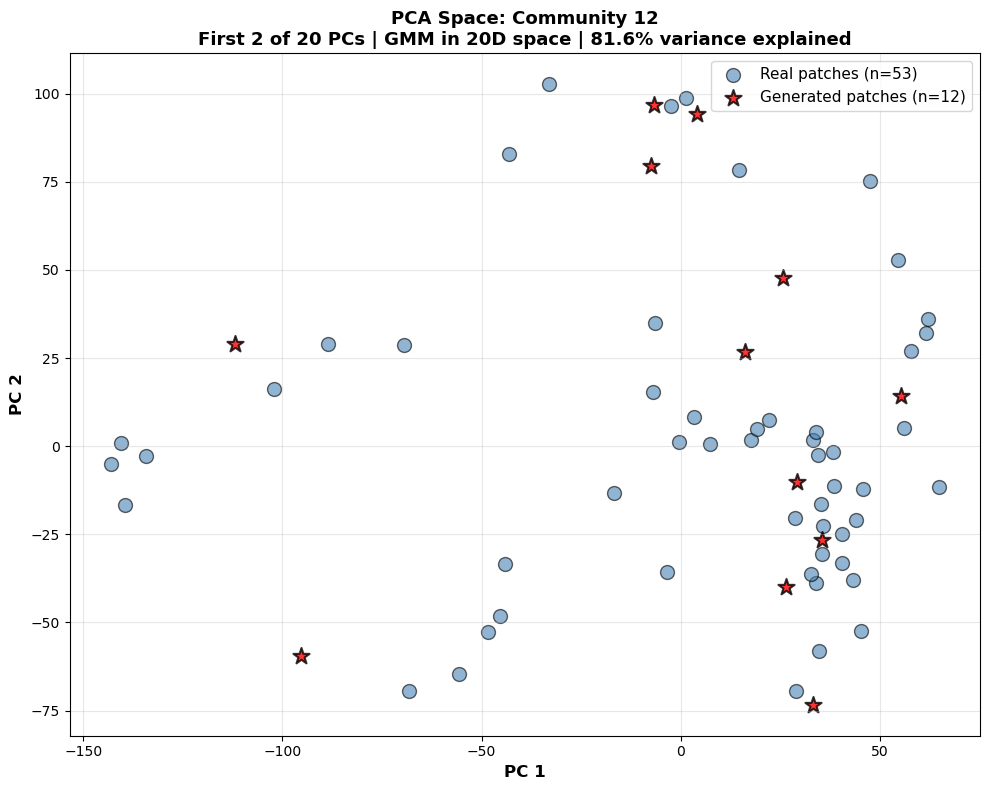

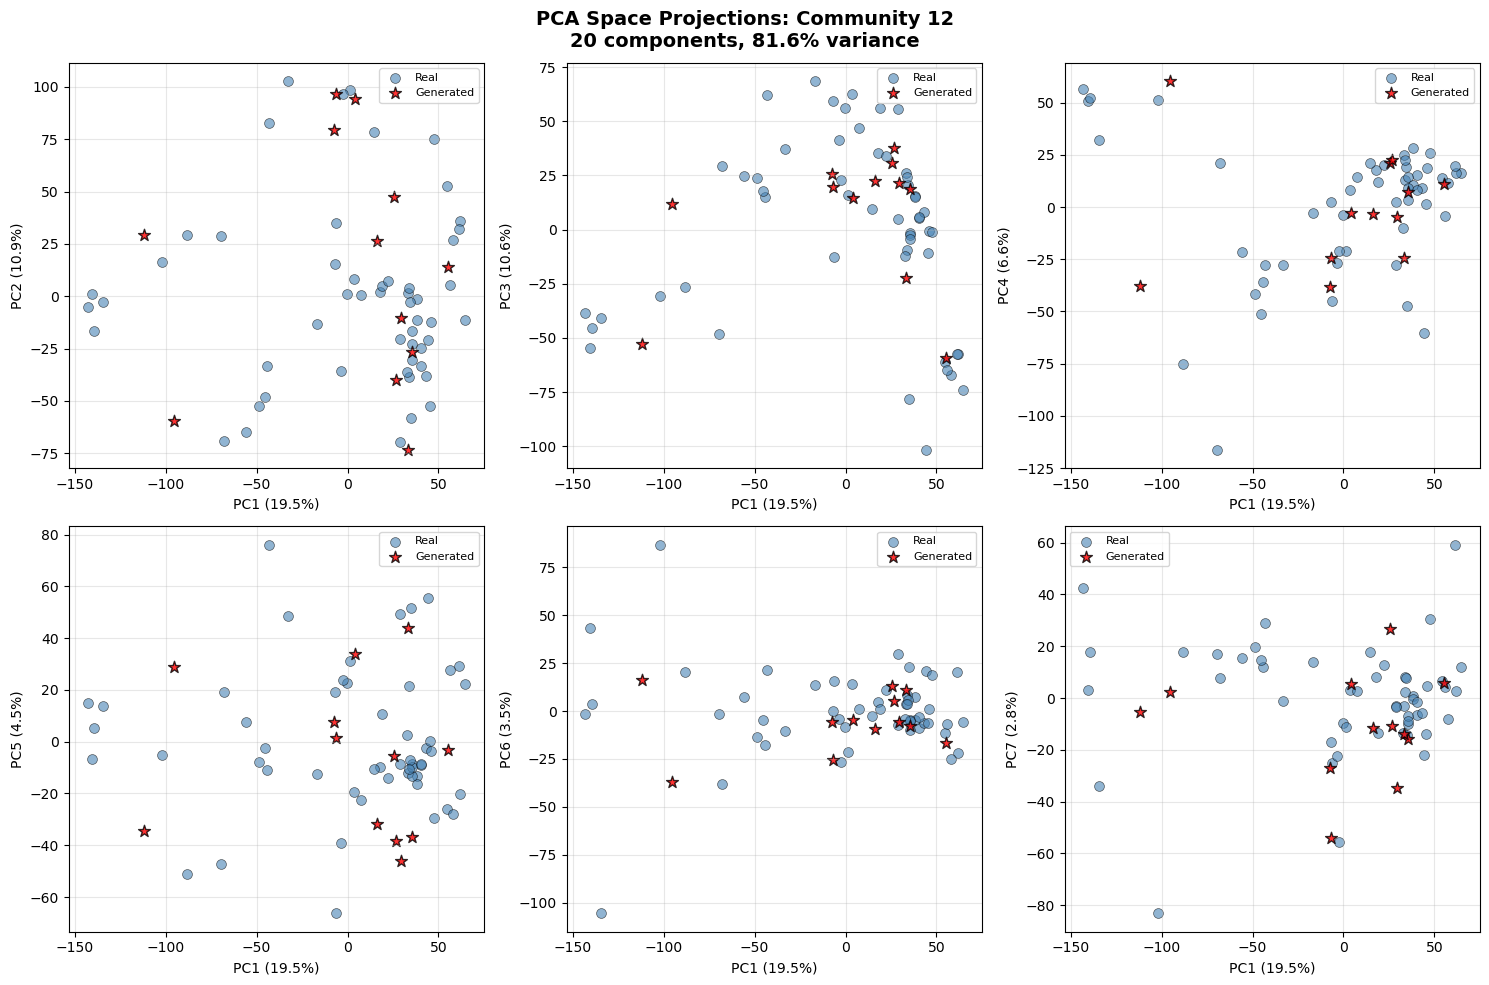

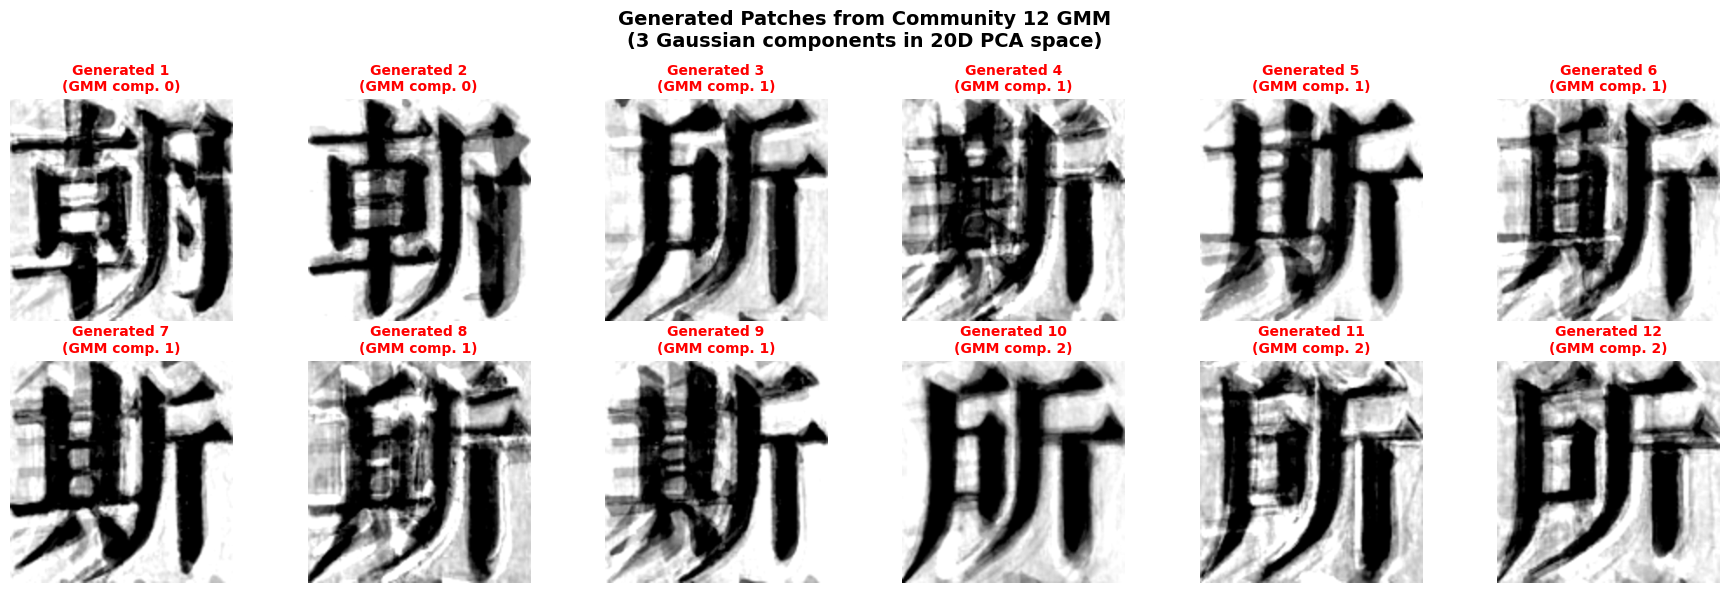

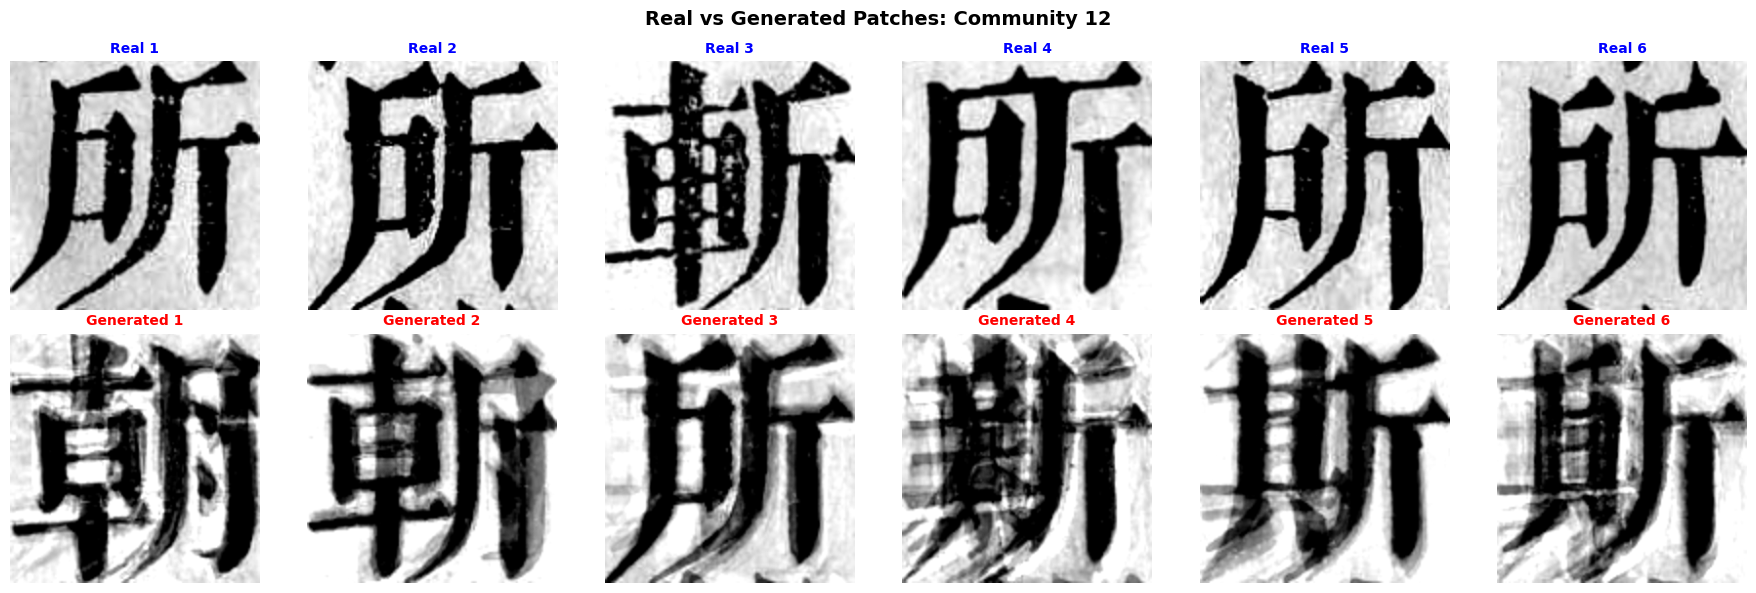


✓ Generation complete!
  - PCA captured 81.6% of variance with 20 components
  - GMM fit with 3 components (BIC: 7462.0)
  - Generated 12 new patches


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch

# ============================================================================
# GMM GENERATION FROM COMMUNITY PCA SPACE
# ============================================================================

# Pick a random community (with minimum size for meaningful PCA)
MIN_SIZE_FOR_GMM = 50
valid_communities = [i for i, comm in enumerate(communities) if len(comm) >= MIN_SIZE_FOR_GMM]

if len(valid_communities) == 0:
    print(f"⚠️  No communities with at least {MIN_SIZE_FOR_GMM} patches found!")
else:
    # Select random community
    selected_comm_idx = np.random.choice(valid_communities)
    community_indices = list(communities[selected_comm_idx])
    community_size = len(community_indices)
    
    print(f"\n{'='*60}")
    print(f"GMM Generation from Community {selected_comm_idx}")
    print(f"{'='*60}")
    print(f"Community size: {community_size} patches")
    
    # Get patches from community
    community_patches = [extracted_image_patches[idx].unsqueeze(0) for idx in community_indices]
    community_patches_flat = torch.stack([patch.flatten() for patch in community_patches]).cpu().numpy()
    
    # Standardize
    scaler = StandardScaler()
    community_patches_scaled = scaler.fit_transform(community_patches_flat)
    
    # Apply PCA with n_components (can be 2 or more)
    n_components = min(20, community_size - 1)  # Adjust this number as needed
    pca = PCA(n_components=n_components)
    community_pca = pca.fit_transform(community_patches_scaled)
    
    print(f"PCA: {n_components} components explain {pca.explained_variance_ratio_.sum()*100:.1f}% variance")
    
    # Fit GMM on PCA space
    n_gmm_components = min(3, community_size // 3)  # Avoid overfitting
    gmm = GaussianMixture(n_components=n_gmm_components, random_state=42, covariance_type='full')
    gmm.fit(community_pca)
    
    print(f"GMM: fitted with {n_gmm_components} Gaussian components")
    print(f"GMM converged: {gmm.converged_}, iterations: {gmm.n_iter_}")
    
    # Generate new samples in PCA space
    n_generated = 12
    generated_pca, generated_labels = gmm.sample(n_generated)
    
    print(f"Generated {n_generated} new samples in PCA space")
    
    # Transform back to original space
    generated_scaled = pca.inverse_transform(generated_pca)
    generated_patches_flat = scaler.inverse_transform(generated_scaled)
    
    # Reshape to patch shape
    patch_shape = community_patches[0].shape
    generated_patches = [generated_patches_flat[i].reshape(patch_shape) for i in range(n_generated)]
    
    # Clip to valid range [0, 1] if needed
    generated_patches = [np.clip(patch, 0, 1) for patch in generated_patches]
    
    # ============================================================================
    # VISUALIZATION 1: PCA Space (only if n_components == 2 or visualizing first 2)
    # ============================================================================
    
    if n_components >= 2:
        plt.figure(figsize=(10, 8))
        
        # Plot real patches (first 2 PCs)
        plt.scatter(community_pca[:, 0], community_pca[:, 1], 
                   c='steelblue', s=100, alpha=0.6, edgecolors='black', linewidth=1,
                   label=f'Real patches (n={community_size})')
        
        # Plot generated patches (first 2 PCs)
        plt.scatter(generated_pca[:, 0], generated_pca[:, 1], 
                   c='red', s=150, alpha=0.8, marker='*', edgecolors='black', linewidth=1.5,
                   label=f'Generated patches (n={n_generated})')
        
        # Plot GMM contours (only for 2D visualization)
        if n_components == 2:
            x_min, x_max = community_pca[:, 0].min() - 1, community_pca[:, 0].max() + 1
            y_min, y_max = community_pca[:, 1].min() - 1, community_pca[:, 1].max() + 1
            xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
            Z = -gmm.score_samples(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=10, linewidths=1, colors='orange', alpha=0.5)
            title_suffix = f'GMM with {n_gmm_components} components'
        else:
            title_suffix = f'First 2 of {n_components} PCs | GMM in {n_components}D space'
        
        plt.xlabel('PC 1', fontsize=12, fontweight='bold')
        plt.ylabel('PC 2', fontsize=12, fontweight='bold')
        plt.title(f'PCA Space: Community {selected_comm_idx}\n'
                  f'{title_suffix} | {pca.explained_variance_ratio_.sum()*100:.1f}% variance explained', 
                  fontsize=13, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # ============================================================================
    # VISUALIZATION 1b: PCA Pairwise Scatter (if n_components > 2)
    # ============================================================================
    
    if n_components > 2:
        n_pairs_to_show = min(6, n_components * (n_components - 1) // 2)
        n_cols_pairs = 3
        n_rows_pairs = int(np.ceil(n_pairs_to_show / n_cols_pairs))
        
        fig, axs = plt.subplots(n_rows_pairs, n_cols_pairs, figsize=(15, 5 * n_rows_pairs))
        axs = np.atleast_2d(axs).ravel()
        
        pair_idx = 0
        for i in range(n_components):
            for j in range(i + 1, n_components):
                if pair_idx >= n_pairs_to_show:
                    break
                
                ax = axs[pair_idx]
                
                # Plot real patches
                ax.scatter(community_pca[:, i], community_pca[:, j], 
                          c='steelblue', s=50, alpha=0.6, edgecolors='black', linewidth=0.5,
                          label='Real')
                
                # Plot generated patches
                ax.scatter(generated_pca[:, i], generated_pca[:, j], 
                          c='red', s=80, alpha=0.8, marker='*', edgecolors='black', linewidth=1,
                          label='Generated')
                
                var_i = pca.explained_variance_ratio_[i] * 100
                var_j = pca.explained_variance_ratio_[j] * 100
                ax.set_xlabel(f'PC{i+1} ({var_i:.1f}%)', fontsize=10)
                ax.set_ylabel(f'PC{j+1} ({var_j:.1f}%)', fontsize=10)
                ax.legend(fontsize=8)
                ax.grid(alpha=0.3)
                
                pair_idx += 1
        
        # Hide unused subplots
        for idx in range(pair_idx, len(axs)):
            axs[idx].axis('off')
            axs[idx].set_visible(False)
        
        plt.suptitle(f'PCA Space Projections: Community {selected_comm_idx}\n'
                     f'{n_components} components, {pca.explained_variance_ratio_.sum()*100:.1f}% variance', 
                     fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    # ============================================================================
    # VISUALIZATION 2: Generated Patches
    # ============================================================================
    
    n_cols = min(6, n_generated)
    n_rows = int(np.ceil(n_generated / n_cols))
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
    axs = np.atleast_2d(axs).ravel()
    
    for i in range(n_generated):
        ax = axs[i]
        patch_tensor = torch.from_numpy(generated_patches[i]).float()
        ax.imshow(torch_to_pil(patch_tensor).resize((256, 256)), cmap="gray")
        ax.set_title(f'Generated {i+1}\n(GMM comp. {generated_labels[i]})', 
                    fontweight='bold', fontsize=10, color='red')
        ax.axis('off')
        for spine in ax.spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(3)
            spine.set_visible(True)
    
    # Hide unused subplots
    for i in range(n_generated, len(axs)):
        axs[i].axis('off')
        axs[i].set_visible(False)
    
    plt.suptitle(f'Generated Patches from Community {selected_comm_idx} GMM\n'
                 f'({n_gmm_components} Gaussian components in {n_components}D PCA space)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # ============================================================================
    # VISUALIZATION 3: Comparison - Real vs Generated
    # ============================================================================
    
    # Show some real patches for comparison
    n_real_to_show = min(6, community_size)
    real_sample_indices = np.random.choice(len(community_indices), n_real_to_show, replace=False)
    
    fig, axs = plt.subplots(2, max(n_real_to_show, n_cols), 
                            figsize=(3 * max(n_real_to_show, n_cols), 6))
    
    # Top row: Real patches
    for i in range(n_real_to_show):
        ax = axs[0, i]
        patch_idx = community_indices[real_sample_indices[i]]
        ax.imshow(torch_to_pil(extracted_image_patches[patch_idx].unsqueeze(0)).resize((256, 256)), cmap="gray")
        ax.set_title(f'Real {i+1}', fontweight='bold', fontsize=10, color='blue')
        ax.axis('off')
        for spine in ax.spines.values():
            spine.set_edgecolor('blue')
            spine.set_linewidth(2)
            spine.set_visible(True)
    
    # Hide extra subplots in first row
    for i in range(n_real_to_show, axs.shape[1]):
        axs[0, i].axis('off')
        axs[0, i].set_visible(False)
    
    # Bottom row: Generated patches
    for i in range(min(n_generated, axs.shape[1])):
        ax = axs[1, i]
        patch_tensor = torch.from_numpy(generated_patches[i]).float()
        ax.imshow(torch_to_pil(patch_tensor).resize((256, 256)), cmap="gray")
        ax.set_title(f'Generated {i+1}', fontweight='bold', fontsize=10, color='red')
        ax.axis('off')
        for spine in ax.spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(2)
            spine.set_visible(True)
    
    # Hide extra subplots in second row
    for i in range(min(n_generated, axs.shape[1]), axs.shape[1]):
        axs[1, i].axis('off')
        axs[1, i].set_visible(False)
    
    plt.suptitle(f'Real vs Generated Patches: Community {selected_comm_idx}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Generation complete!")
    print(f"  - PCA captured {pca.explained_variance_ratio_.sum()*100:.1f}% of variance with {n_components} components")
    print(f"  - GMM fit with {n_gmm_components} components (BIC: {gmm.bic(community_pca):.1f})")
    print(f"  - Generated {n_generated} new patches")

In [ ]:
%matplotlib tk

In [ ]:
(patches[communities[comms_to_save[0]].pop()]*255).to(torch.uint8).numpy()

error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)


(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)

In [ ]:
%matplotlib tk


https://arxiv.org/pdf/1511.00628

https://www.ipol.im/pub/art/2018/222/

https://en.wikipedia.org/wiki/Fisher%E2%80%93Tippett%E2%80%93Gnedenko_theorem


Parler à Diego -> du gaussianity test

Idées:
- Gaussianity test
- VP Tree pour scaler
- Preprocess les patchs avec l'algo de SVG
- Recalage avec l'algo d'IPOL

In [ ]:
# ============================================
# Community Statistics and Analysis
# ============================================

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
import networkx as nx

# Create undirected version if not exists
if 'G_undirected' not in locals():
    if G.is_directed():
        G_undirected = G.to_undirected()
    else:
        G_undirected = G

# Compute degrees if not already computed
if 'in_degrees' not in locals():
    if G.is_directed():
        in_degrees = np.array([G.in_degree(i) for i in range(N)])
        out_degrees = np.array([G.out_degree(i) for i in range(N)])
    else:
        # For undirected graphs, in_degree = out_degree = degree
        in_degrees = np.array([G.degree(i) for i in range(N)])
        out_degrees = np.array([G.degree(i) for i in range(N)])
    
if 'degrees' not in locals():
    if G.is_directed():
        degrees = in_degrees + out_degrees
    else:
        degrees = np.array([G.degree(i) for i in range(N)])

print("=" * 70)
print("COMMUNITY STATISTICS")
print("=" * 70)

# Basic statistics
print(f"\nGraph type: {'Directed' if G.is_directed() else 'Undirected'}")
print(f"Total nodes: {N}")
print(f"Total edges: {G.number_of_edges()}")
print(f"Total communities: {len(communities)}")
print(f"Graph density: {nx.density(G_undirected):.4f}")

# Modularity (measure of community structure quality)
if G_undirected.number_of_edges() > 0:
    from networkx.algorithms import community as comm_module
    modularity = comm_module.modularity(G_undirected, communities)
    print(f"Modularity: {modularity:.4f} (higher is better, typically 0.3-0.7 is good)")

# Community size statistics
community_sizes = [len(comm) for comm in communities]
print(f"\nCommunity size statistics:")
print(f"  Mean: {np.mean(community_sizes):.2f}")
print(f"  Median: {np.median(community_sizes):.2f}")
print(f"  Min: {np.min(community_sizes)}")
print(f"  Max: {np.max(community_sizes)}")
print(f"  Std: {np.std(community_sizes):.2f}")

# Largest communities
print(f"\nTop 10 largest communities:")
sorted_communities = sorted(enumerate(communities), key=lambda x: len(x[1]), reverse=True)
for rank, (comm_idx, comm) in enumerate(sorted_communities[:10], 1):
    print(f"  {rank}. Community {comm_idx}: {len(comm)} nodes ({100*len(comm)/N:.1f}%)")

# Degree statistics per community
print(f"\nDegree statistics by community (top 5):")
for comm_idx, comm in sorted_communities[:5]:
    comm_degrees = degrees[list(comm)]
    if G.is_directed():
        comm_in = in_degrees[list(comm)]
        comm_out = out_degrees[list(comm)]
        print(f"  Community {comm_idx} ({len(comm)} nodes):")
        print(f"    Avg degree: {comm_degrees.mean():.2f} (in: {comm_in.mean():.2f}, out: {comm_out.mean():.2f})")
        print(f"    Max degree: {comm_degrees.max()} (in: {comm_in.max()}, out: {comm_out.max()})")
    else:
        print(f"  Community {comm_idx} ({len(comm)} nodes):")
        print(f"    Avg degree: {comm_degrees.mean():.2f}")
        print(f"    Max degree: {comm_degrees.max()}")

# Edge analysis
intra_edges = sum(1 for i, j in G.edges() 
                  if community_map.get(i, -1) == community_map.get(j, -1))
inter_edges = G.number_of_edges() - intra_edges
print(f"\nEdge distribution:")
print(f"  Intra-community edges: {intra_edges} ({100*intra_edges/G.number_of_edges():.1f}%)")
print(f"  Inter-community edges: {inter_edges} ({100*inter_edges/G.number_of_edges():.1f}%)")

# ============================================
# Visualizations
# ============================================

fig = plt.figure(figsize=(20, 12))

# 1. Community size distribution
ax1 = plt.subplot(2, 3, 1)
ax1.hist(community_sizes, bins=min(30, len(communities)), 
         color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Community Size', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Community Size Distribution', fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3)

# 2. Top communities pie chart
ax2 = plt.subplot(2, 3, 2)
top_n = 10
top_communities = sorted_communities[:top_n]
top_sizes = [len(comm) for _, comm in top_communities]
other_size = N - sum(top_sizes)

if other_size > 0:
    labels = [f'C{idx} ({len(comm)})' for idx, comm in top_communities] + [f'Others ({other_size})']
    sizes = top_sizes + [other_size]
    colors_pie = [community_colors[idx] for idx, _ in top_communities] + [[0.8, 0.8, 0.8, 1.0]]
else:
    labels = [f'C{idx} ({len(comm)})' for idx, comm in top_communities]
    sizes = top_sizes
    colors_pie = [community_colors[idx] for idx, _ in top_communities]

ax2.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.1f%%', startangle=90)
ax2.set_title(f'Top {top_n} Communities Distribution', fontsize=13, fontweight='bold')

# 3. Degree distribution
ax3 = plt.subplot(2, 3, 3)
ax3.hist(degrees, bins=50, color='coral', edgecolor='black', alpha=0.7)
ax3.set_xlabel('Total Degree', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Node Degree Distribution', fontsize=13, fontweight='bold')
ax3.axvline(degrees.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {degrees.mean():.1f}')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. In-degree vs Out-degree scatter (only for directed graphs)
ax4 = plt.subplot(2, 3, 4)
if G.is_directed():
    scatter = ax4.scatter(out_degrees, in_degrees, c=node_communities, 
                         cmap='tab20', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax4.set_xlabel('Out-Degree', fontsize=12)
    ax4.set_ylabel('In-Degree', fontsize=12)
    ax4.set_title('In-Degree vs Out-Degree (colored by community)', fontsize=13, fontweight='bold')
    ax4.plot([0, max(out_degrees.max(), in_degrees.max())], 
             [0, max(out_degrees.max(), in_degrees.max())], 
             'r--', alpha=0.5, label='Equal in/out')
    ax4.legend()
else:
    # For undirected graph, show degree vs community size
    comm_sizes_per_node = [len(communities[community_map.get(i, 0)]) for i in range(N)]
    scatter = ax4.scatter(comm_sizes_per_node, degrees, c=node_communities,
                         cmap='tab20', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax4.set_xlabel('Community Size', fontsize=12)
    ax4.set_ylabel('Node Degree', fontsize=12)
    ax4.set_title('Degree vs Community Size (colored by community)', fontsize=13, fontweight='bold')
ax4.grid(alpha=0.3)

# 5. Community connectivity matrix (top communities)
ax5 = plt.subplot(2, 3, 5)
top_comm_indices = [idx for idx, _ in sorted_communities[:10]]
connectivity_matrix = np.zeros((len(top_comm_indices), len(top_comm_indices)))

for i, j in G.edges():
    comm_i = community_map.get(i, -1)
    comm_j = community_map.get(j, -1)
    if comm_i in top_comm_indices and comm_j in top_comm_indices:
        i_idx = top_comm_indices.index(comm_i)
        j_idx = top_comm_indices.index(comm_j)
        connectivity_matrix[i_idx, j_idx] += 1
        if not G.is_directed() and i != j:
            # For undirected graphs, count both directions
            connectivity_matrix[j_idx, i_idx] += 1

im = ax5.imshow(connectivity_matrix, cmap='YlOrRd', aspect='auto')
ax5.set_xticks(range(len(top_comm_indices)))
ax5.set_yticks(range(len(top_comm_indices)))
ax5.set_xticklabels([f'C{idx}' for idx in top_comm_indices], rotation=45)
ax5.set_yticklabels([f'C{idx}' for idx in top_comm_indices])
if G.is_directed():
    ax5.set_xlabel('To Community', fontsize=12)
    ax5.set_ylabel('From Community', fontsize=12)
else:
    ax5.set_xlabel('Community', fontsize=12)
    ax5.set_ylabel('Community', fontsize=12)
ax5.set_title('Top 10 Communities Connectivity', fontsize=13, fontweight='bold')
plt.colorbar(im, ax=ax5, label='Number of edges')

# 6. Nodes per community (top 20)
ax6 = plt.subplot(2, 3, 6)
top_20_communities = sorted_communities[:20]
comm_labels = [f'C{idx}' for idx, _ in top_20_communities]
comm_sizes_top = [len(comm) for _, comm in top_20_communities]
colors_bars = [community_colors[idx] for idx, _ in top_20_communities]

bars = ax6.barh(range(len(comm_labels)), comm_sizes_top, color=colors_bars, edgecolor='black')
ax6.set_yticks(range(len(comm_labels)))
ax6.set_yticklabels(comm_labels)
ax6.set_xlabel('Number of Nodes', fontsize=12)
ax6.set_ylabel('Community', fontsize=12)
ax6.set_title('Top 20 Communities by Size', fontsize=13, fontweight='bold')
ax6.invert_yaxis()
ax6.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================
# Additional Analysis
# ============================================

print("\n" + "=" * 70)
print("ISOLATED NODES AND HUBS")
print("=" * 70)

# Isolated nodes
isolated = [i for i in range(N) if degrees[i] == 0]
print(f"\nIsolated nodes (degree = 0): {len(isolated)}")
if len(isolated) > 0 and len(isolated) <= 10:
    print(f"  Node indices: {isolated}")

# Hub nodes (high degree)
degree_threshold = np.percentile(degrees[degrees > 0], 90) if len(degrees[degrees > 0]) > 0 else 0
hubs = [(i, degrees[i], in_degrees[i], out_degrees[i]) 
        for i in range(N) if degrees[i] >= degree_threshold]
hubs.sort(key=lambda x: x[1], reverse=True)

print(f"\nTop 10 hub nodes (≥ 90th percentile degree = {degree_threshold:.0f}):")
for rank, (node, deg, in_deg, out_deg) in enumerate(hubs[:10], 1):
    comm = community_map.get(node, -1)
    if G.is_directed():
        print(f"  {rank}. Node {node}: degree={deg} (in={in_deg}, out={out_deg}), community={comm}")
    else:
        print(f"  {rank}. Node {node}: degree={deg}, community={comm}")

# Inter-community bridge nodes
print(f"\nBridge nodes (nodes connecting multiple communities):")
bridge_nodes = []
for node in range(N):
    neighbors_communities = set()
    for neighbor in G.neighbors(node):
        neighbors_communities.add(community_map.get(neighbor, -1))
    if len(neighbors_communities) > 1:
        bridge_nodes.append((node, len(neighbors_communities), degrees[node]))

bridge_nodes.sort(key=lambda x: (x[1], x[2]), reverse=True)
print(f"  Total bridge nodes: {len(bridge_nodes)}")
if len(bridge_nodes) > 0:
    print(f"  Top 10 bridges:")
    for rank, (node, n_comms, deg) in enumerate(bridge_nodes[:10], 1):
        print(f"    {rank}. Node {node}: connects {n_comms} communities, degree={deg}")

print("\n" + "=" * 70)

COMMUNITY STATISTICS

Graph type: Undirected
Total nodes: 14628
Total edges: 242043
Total communities: 4237
Graph density: 0.0023
Modularity: 0.8422 (higher is better, typically 0.3-0.7 is good)

Community size statistics:
  Mean: 3.45
  Median: 1.00
  Min: 1
  Max: 435
  Std: 16.69

Top 10 largest communities:
  1. Community 0: 435 nodes (3.0%)
  2. Community 1: 394 nodes (2.7%)
  3. Community 2: 394 nodes (2.7%)
  4. Community 3: 343 nodes (2.3%)
  5. Community 4: 284 nodes (1.9%)
  6. Community 5: 223 nodes (1.5%)
  7. Community 6: 184 nodes (1.3%)
  8. Community 7: 154 nodes (1.1%)
  9. Community 8: 152 nodes (1.0%)
  10. Community 9: 149 nodes (1.0%)

Degree statistics by community (top 5):
  Community 0 (435 nodes):
    Avg degree: 113.19
    Max degree: 245
  Community 1 (394 nodes):
    Avg degree: 249.56
    Max degree: 362
  Community 2 (394 nodes):
    Avg degree: 296.73
    Max degree: 372
  Community 3 (343 nodes):
    Avg degree: 75.08
    Max degree: 173
  Community 4 (2

NameError: name 'community_map' is not defined